# Hodoscope analysis

In [1]:
import os
import uproot
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import hodoscope_functions as hd

from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from scipy.stats import norm, moyal
from scipy.signal import find_peaks

#pd.options.display.max_columns = 500
#pd.options.display.max_rows = 100000

In [2]:
ntuple_dir = "/Users/jrenner/local/jerenner/T9BeamTestAna/ntuple/"
ntuple_pd_dir = "/Users/jrenner/local/jerenner/T9BeamTestAna/ntuple_dataframes/"

# 1. Gamma peak analysis

In [ ]:
ntuple_dir = "/Users/jrenner/local/data/beamtest/ntuple_files/"
ntuple_pd_dir = "/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/"

In [ ]:
runs = [731, 732, 733, 734, 735, 736, 737, 738, 753, 754, 755, 756, 760, 763, 764, 765]
rmomenta = [460, 500, 600, 700, 800, 900, 1000, 1200, 500, 600, 700, 800, 1000, 900, 1200, 800]

In [ ]:
# Timing and charge ranges for filters.
pb_timing_range = (45, 75)
tof0_timing_range = (45, 85)
tof0_charge_range = (0.3, 1.0)
tof1_timing_range = (60, 100)
tof1_charge_range = (0.3, 1.0)
t2_timing_range = (160, 180)
t2_charge_range = (0.01, 0.0225)
act0_timing_range = (130, 175)
act0_charge_range = (0.1, 1.0)
act1_timing_range = (130, 175)
act1_charge_range = (0.02, 0.2)
act3_timing_range = (150, 190)
hd_timing_ranges = {
    'HD0': (35, 75),
    'HD1': (35, 75),
    'HD2': (35, 75),
    'HD3': (35, 75),
    'HD4': (35, 75),
    'HD5': (35, 75),
    'HD6': (35, 75),
    'HD7': (35, 75),
    'HD8': (80, 120),
    'HD9': (80, 120),
    'HD10': (80, 120),
    'HD11': (80, 120),
    'HD12': (80, 120),
    'HD13': (80, 120),
    'HD14': (80, 120)
}
hd_charge_ranges = {
    'HD0': (0.12, 0.3),
    'HD1': (0.09, 0.2),
    'HD2': (0.06, 0.15),
    'HD3': (0.075, 0.2),
    'HD4': (0.075, 0.2),
    'HD5': (0.1, 0.3),
    'HD6': (0.1, 0.3),
    'HD7': (0.1, 0.3),
    'HD8': (0.085, 0.285),
    'HD9': (0.085, 0.285),
    'HD10': (0.1, 0.3),
    'HD11': (0.075, 0.275),
    'HD12': (0.1, 0.3),
    'HD13': (0.1, 0.4),
    'HD14': (0.1, 0.4)    
}

## 1a. Multi-run analysis

In [ ]:
# Run the gamma peak analysis for all runs.
all_fit_results, all_fit_arrays = [], []
all_ntot_evts, all_ntot_spills, all_ntot_tagged_evts = [], [], []
for rnum, pbeam in zip(runs, rmomenta):
    
    print("Processing run",rnum,"...")
    df_dict = hd.read_dataframes_from_csv("/Users/jrenner/temp/hk/beamtest/ntuple_dataframes/run000{}".format(rnum))
    
    # Run the timing analysis (event selection).
    final_df, ntot_evts, ntot_spills, ntot_tagged_evts = hd.timing_analysis(df_dict, pb_timing_range, tof0_timing_range, tof0_charge_range, 
                    tof1_timing_range, tof1_charge_range, t2_timing_range, t2_charge_range,
                    act0_timing_range, act0_charge_range, act1_timing_range, act1_charge_range,
                    act3_timing_range, hd_timing_ranges, hd_charge_ranges)
    
    # Save the results of the gamma peak fits for plotting later.
    fit_results, fit_arrays = hd.gamma_peak_plots(final_df, rnum, pbeam, base_dir='plt/gamma_peaks', nbins=80, range=[0,0.8])
    
    all_fit_results.append(fit_results)
    all_fit_arrays.append(fit_arrays)
    all_ntot_evts.append(ntot_evts)
    all_ntot_spills.append(ntot_spills)
    all_ntot_tagged_evts.append(ntot_tagged_evts)
    
all_fit_results = np.array(all_fit_results)
all_fit_arrays = np.array(all_fit_arrays)

In [ ]:
print(len(final_df[final_df.total_hits == 1]))
print(ntot_tagged_evts)

#### Summary of data (*tbl.data*)

In [ ]:
# Print table of results.
for rnum,p,nevts,nspills in zip(runs, rmomenta, all_ntot_evts, all_ntot_spills):
    print(f"{rnum} & {p} & {nevts} & {nspills} & \\\\")

In [ ]:
print(all_ntot_tagged_evts/np.array(all_ntot_evts))

#### Tagged events per spill

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

all_ntot_spills = np.array(all_ntot_spills)
all_ntot_tagged_evts = np.array(all_ntot_tagged_evts)

ax.plot(rmomenta,all_ntot_tagged_evts/all_ntot_spills,'o',color='black')
ax.set_ylim([0,400])
ax.set_xlabel("Beam momentum (MeV/c)",fontsize=14)
ax.set_ylabel("Tagged photons/spill",fontsize=14)
plt.savefig("tagged_evts_per_spill.pdf",bbox_inches='tight')

#### Lead glass calibration plot (*fig.LG_calibration*)

In [ ]:
# Plot all gamma peak means and fit lines on the same plot.
elec_hit_momenta_values = [v for v in hd.elec_hit_momenta.values()]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
momentum_color = {460: "red", 500: "orange", 600: "yellow", 700: "green", 
                  800: "blue", 900: "violet", 1000: "gray", 1100: "brown", 1200: "black"}
momentum_plt   = {460: False, 500: False, 600: False, 700: False,
                  800: False, 900: False, 1000: False, 1100: False, 1200: False}

all_e_gamma_expected = []
for run_momentum, fit_array in zip(rmomenta,all_fit_arrays):
    
    # Get the fit means and errors for this run.
    fit_means, fit_smeans = fit_array[0], fit_array[1]

    e_gamma_expected = [run_momentum - mval*1000 for mval in elec_hit_momenta_values[::-1]]
    all_e_gamma_expected.append(e_gamma_expected)
    
    if(not momentum_plt[run_momentum]):
        ax.errorbar(e_gamma_expected, fit_means, yerr=fit_smeans, fmt='.', 
                    color=momentum_color[run_momentum], label=f"p = {run_momentum} MeV/c")
        momentum_plt[run_momentum] = True
    else:
        ax.errorbar(e_gamma_expected, fit_means, yerr=fit_smeans, fmt='.', 
                    color=momentum_color[run_momentum])
        
# Fit a line to all results at once.
all_fit_means = all_fit_arrays[:,0,:].flatten()
all_fit_smeans = all_fit_arrays[:,1,:].flatten()
all_e_gamma_expected = np.array(all_e_gamma_expected).flatten()

p0 = [(np.max(all_e_gamma_expected) - np.min(all_e_gamma_expected))/(np.max(all_fit_means) - np.min(all_fit_means)),all_e_gamma_expected[0]]
popt, pcov = curve_fit(hd.line, all_e_gamma_expected, all_fit_means, p0, sigma=all_fit_smeans)
x = np.linspace(50, 1120, 1000)
y = hd.line(x, *popt)
perr = np.sqrt(np.diag(pcov))
#ax.plot(x, y, label='C = $({:.2f} \pm {:.2f}) x 10^{{-4}} \cdot $p + $({:.3f} \pm {:.4f})$'.format(popt[0]*10000,perr[0]*10000,popt[1],perr[1]), color='red', alpha=0.8, linewidth=3, linestyle=':')
ax.plot(x, y, color='black', alpha=0.8, linewidth=1, linestyle='-')
ax.annotate("---- C = $({:.2f} \pm {:.2f}) x 10^{{-4}} \cdot $E + $({:.3f} \pm {:.4f})$".format(popt[0]*10000,perr[0]*10000,popt[1],perr[1]), xy=(500, 0.10), xytext=(200, 0.01), fontsize=14, fontweight='bold', color='black')

ax.legend(title="Beam momentum",title_fontsize=12,fontsize=11)
ax.set_ylabel('Lead glass charge [arbitrary units]',fontsize=14)
ax.set_xlabel('Expected energy [MeV]',fontsize=14)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.savefig("LG_calibration.pdf", bbox_inches='tight')

In [ ]:
# Plot the slope and intercept of the calibration curve vs. momentum
mvals = all_fit_results[:,0]
merr = all_fit_results[:,1]
bvals = all_fit_results[:,2]
berr = all_fit_results[:,3]
fvals = all_fit_results[:,4]
ferr = all_fit_results[:,5]
cvals = all_fit_results[:,6]
cerr = all_fit_results[:,7]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
flat_axes = axes.ravel()

flat_axes[0].errorbar(rmomenta,mvals*10000,yerr=merr*10000,fmt='o')
flat_axes[0].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[0].set_ylabel('Slope $x 10^{-4}$ (LG charge)/MeV',fontsize=20)
flat_axes[0].tick_params(axis="x", labelsize=14)
flat_axes[0].tick_params(axis="y", labelsize=14)

flat_axes[1].errorbar(rmomenta,bvals,yerr=berr,fmt='o')
flat_axes[1].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[1].set_ylabel('Intercept (LG charge)',fontsize=20)
flat_axes[1].tick_params(axis="x", labelsize=14)
flat_axes[1].tick_params(axis="y", labelsize=14)

flat_axes[2].errorbar(rmomenta,fvals,yerr=ferr,fmt='o')
flat_axes[2].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[2].set_ylabel('Parameter F',fontsize=20)
flat_axes[2].tick_params(axis="x", labelsize=14)
flat_axes[2].tick_params(axis="y", labelsize=14)

flat_axes[3].errorbar(rmomenta,cvals,yerr=cerr,fmt='o')
flat_axes[3].set_xlabel('Beam momentum (MeV/c)',fontsize=20)
flat_axes[3].set_ylabel('Parameter C',fontsize=20)
flat_axes[3].tick_params(axis="x", labelsize=14)
flat_axes[3].tick_params(axis="y", labelsize=14)

## 1b. Single-run analysis

In [3]:
def gauss(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

In [4]:
# Read in all dataframes from a given run
rnum = 735
low_radiation = False
pbeam = 800
df_dict = hd.read_dataframes_from_csv(f"{ntuple_pd_dir}run000{rnum}")
df_dict.keys()

dict_keys(['EventInfo', 'ACT0L', 'ACT1L', 'ACT3R', 'TOF01', 'HD3', 'HD11', 'HD10', 'HD2', 'TOF00', 'HD0', 'TOF02', 'HD12', 'HD13', 'TOF03', 'HD1', 'TOF13', 'HD5', 'PbGlass', 'TOF12', 'HD4', 'HD6', 'TOF10', 'HD14', 'HD7', 'TOF11', 'HD9', 'HD8', 'TriggerScint', 'ACT0R', 'ACT1R', 'ACT3L'])

In [5]:
df_dict['HD0'].head()

,event,iPeak,nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,IntCharge,SignalTimeCorrected,IntPE,MaxVoltage,WholeWaveformInt,nWindowPeaks,WindowIntCharge,WindowIntPE,spillNumber
0,0,0,4,1690843780,303675671,1.927209,0.000464,0.001008,49.0,45.748701,0.000040,63.158000,0.001008,0.001719,0.234219,-1.0,-1,-1,-1.0
1,0,1,4,1690843780,303675671,1.927209,0.000464,0.000980,119.0,101.145000,0.000039,118.554298,0.000980,0.001719,0.234219,-1.0,-1,-1,-1.0
2,0,2,4,1690843780,303675671,1.927209,0.000464,0.000980,181.0,178.467727,0.000039,195.877026,0.000980,0.001719,0.234219,-1.0,-1,-1,-1.0
3,0,3,4,1690843780,303675671,1.927209,0.000464,0.001294,195.0,190.678358,0.000052,208.087657,0.001294,0.001719,0.234219,-1.0,-1,-1,-1.0
4,1,-1,0,1690843780,304972953,1.927333,0.000532,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.121419,-1.0,-1,-1,-1.0


In [6]:
def timing_plot(detname, pk_times, t_range, nbins, normed=False, logscale=False):

    # Create the plot
    hist, bin_edges = np.histogram(pk_times, bins=nbins, range=t_range, density=normed)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Gaussian fit
    fit_start = 0
    fit_end = -1
    initial_params = [np.max(hist), np.mean(pk_times), np.std(pk_times)]
    print(f"Initial params: {initial_params}")
    popt, pcov = curve_fit(gauss, bin_centers[fit_start:fit_end], hist[fit_start:fit_end], p0=initial_params)
    perr = np.sqrt(np.diag(pcov))
    fit_curve = gauss(bin_centers[fit_start:fit_end], *popt)

    # Plot the fit peak
    fig = plt.figure(figsize=(8,5))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges)[0], align='edge', color='white')
    plt.plot(bin_edges[:-1], hist, color='black', drawstyle='steps-post')
    plt.plot(bin_centers[fit_start:fit_end], fit_curve, '--', color='red', linewidth=2.0, alpha=1.0)

    # Prepare the legend.
    lbl1 = f"{detname}"
    lbl2 = "$\mu$ = {:.4f} $\pm$ {:.4f}".format(popt[1],perr[1])
    lbl3 = "$\sigma$ = {:.4f} $\pm$ {:.4f}".format(popt[2],perr[2])
    legend_elements = [Line2D([0], [0], color='none', lw=0, label=lbl1),
                       Line2D([0], [0], color='none', lw=0, label=lbl2),
                       Line2D([0], [0], color='none', lw=0, label=lbl3)]
    leg = plt.legend(handles=legend_elements, frameon=True, handlelength=0, fontsize=16)
    for i, text in enumerate(leg.get_texts()):
        if i == 0:
            text.set_weight('bold')
        text.set_horizontalalignment('right')

    plt.xlabel("SignalTimeCorrected",fontsize=18)
    plt.ylabel("Counts/bin",fontsize=18)
    plt.gca().tick_params(axis="x", labelsize=14)
    plt.gca().tick_params(axis="y", labelsize=14)
    if(logscale): plt.yscale('log')

Initial params: [3664, 73.30556835747176, 12.57679053012211]


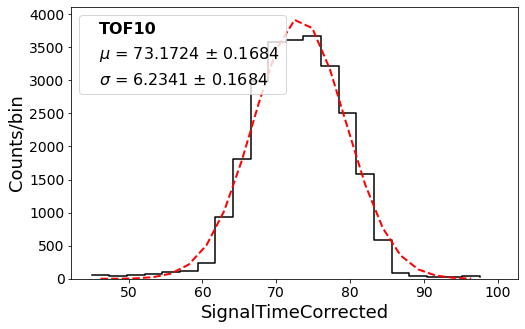

In [7]:
# Make timing plots for all detectors using the SignalTimeCorrected branch
# Consider the time for all detectors relative to TOF10
pk_times = df_dict['TOF10']['SignalTimeCorrected']
t_range = [45,100]
nbins = 23
normed = False
timing_plot('TOF10',pk_times,t_range,nbins)

In [8]:
# Cut on events with peaks in TOF10 at the selected values
df_T1sel = hd.filter_range('TOF10',df_dict['TOF10'],'SignalTimeCorrected',[60,86],drop=True,debug=True)

TOF10 filter passed 24714 of 26457 with 122 duplicates
--> returning 24592 events


In [9]:
tof0_charge_range = (0.03, 1.0)
tof1_charge_range = (0.03, 1.0)

chg_cuts = {
    'ACT0L': (0.1, 2.0),
    'ACT0R': (0.1, 2.0),
    'ACT1L': (0.02, 2.0),
    'ACT1R': (0.02, 2.0),
    'ACT3L': (0.02, 2.0),
    'ACT3R': (0.02, 2.0),
    'TOF00': tof0_charge_range,
    'TOF01': tof0_charge_range,
    'TOF02': tof0_charge_range,
    'TOF03': tof0_charge_range,
    'TOF10': tof1_charge_range,
    'TOF12': tof1_charge_range,
    'TOF13': tof1_charge_range,
    'TOF11': tof1_charge_range,
    'TriggerScint': (0.01, 0.2),
    'PbGlass': (0.01, 0.8),
    'HD0': (0.12, 0.4),
    'HD1': (0.09, 0.4),
    'HD2': (0.06, 0.4),
    'HD3': (0.075, 0.4),
    'HD4': (0.075, 0.4),
    'HD5': (0.1, 0.4),
    'HD6': (0.1, 0.4),
    'HD7': (0.1, 0.4),
    'HD8': (0.085, 0.4),
    'HD9': (0.085, 0.4),
    'HD10': (0.1, 0.6),
    'HD11': (0.075, 0.6),
    'HD12': (0.1, 0.6),
    'HD13': (0.1, 0.6),
    'HD14': (0.1, 0.6)
}

[ACT0L] before selection 37318
[ACT0L] selecting out 129 events to get 195
[ACT0R] before selection 35101
[ACT0R] selecting out 129 events to get 170
[ACT1L] before selection 30491
[ACT1L] selecting out 129 events to get 159
[ACT1R] before selection 33000
[ACT1R] selecting out 129 events to get 159
[ACT3L] before selection 25025
[ACT3L] selecting out 129 events to get 129
[ACT3R] before selection 25087
[ACT3R] selecting out 129 events to get 129
[TOF00] before selection 26678
[TOF00] selecting out 129 events to get 138
[TOF01] before selection 26589
[TOF01] selecting out 129 events to get 135
[TOF02] before selection 27071
[TOF02] selecting out 129 events to get 137
[TOF03] before selection 26987
[TOF03] selecting out 129 events to get 138
[TOF10] before selection 26457
[TOF10] selecting out 129 events to get 136
[TOF11] before selection 26402
[TOF11] selecting out 129 events to get 133
[TOF12] before selection 26684
[TOF12] selecting out 129 events to get 137
[TOF13] before selection 

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


[TriggerScint] before selection 25160
[TriggerScint] selecting out 129 events to get 131
[PbGlass] before selection 27048
[PbGlass] selecting out 129 events to get 129
[HD0] before selection 34950
[HD0] selecting out 129 events to get 188
[HD1] before selection 38307
[HD1] selecting out 129 events to get 201
[HD2] before selection 26450
[HD2] selecting out 129 events to get 138
[HD3] before selection 37602
[HD3] selecting out 129 events to get 211
[HD4] before selection 44413
[HD4] selecting out 129 events to get 228
[HD5] before selection 41767
[HD5] selecting out 129 events to get 230
[HD6] before selection 49096
[HD6] selecting out 129 events to get 265
[HD7] before selection 46325
[HD7] selecting out 129 events to get 234
[HD8] before selection 30966
[HD8] selecting out 129 events to get 164
[HD9] before selection 33584
[HD9] selecting out 129 events to get 177
[HD10] before selection 31374
[HD10] selecting out 129 events to get 176
[HD11] before selection 40130
[HD11] selecting ou

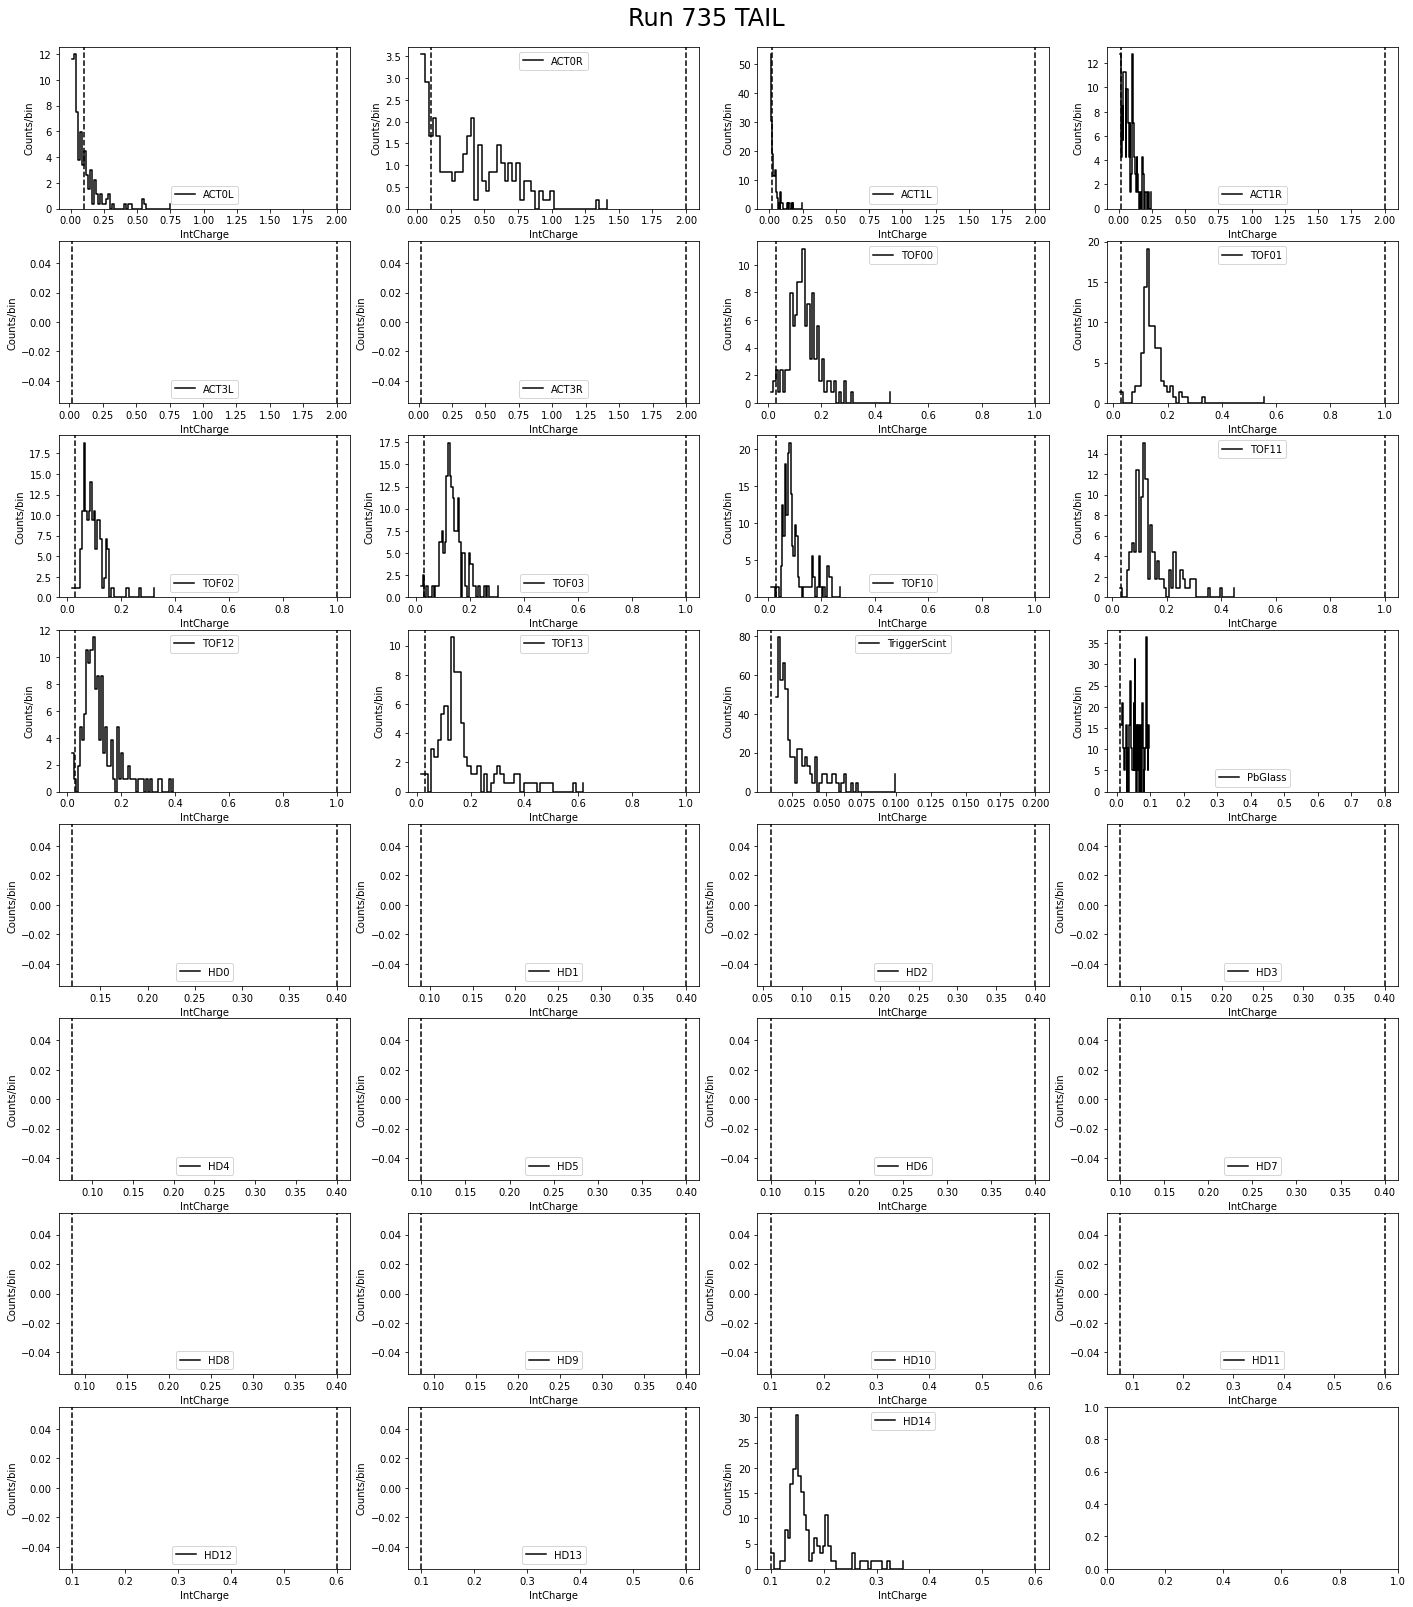

In [71]:
# Plot the charge cuts
evt_list = evt_list_TAIL # None
select_nonzero_peaks = True
windowInt = False
quantity = 'IntCharge'
logscale = False
nbins = 50
normed = True

# Create a grid of 8 rows x 4 columns
fig, axes = plt.subplots(8, 4, figsize=(24, 28))
flat_axes = axes.ravel()

fig.suptitle(f'Run {rnum} TAIL', fontsize=24, y=0.9)

# Iterate based on the custom order
for key, ax in zip(hd.custom_order, flat_axes):
    df = df_dict[key]

    # Cut on the selected events if an event list is provided.
    if(not(evt_list is None)):
        print(f"[{key}] before selection {len(df)}")
        df_select = df[df['event'].isin(evt_list)]
        print(f"[{key}] selecting out {len(evt_list)} events to get {len(df_select)}")
    else:
        df_select = df

    # Select only non-zero peaks if specified.
    if(select_nonzero_peaks):
        if(windowInt):
            df_select = df_select[df_select['nWindowPeaks'] > 0]
        else:
            df_select = df_select[df_select['nPeaks'] > 0]
    # Otherwise, this quantity is event-wide: only keep 1 entry for each event.
    else:
        df_select = df_select.drop_duplicates(subset=['event'], keep='first')

    # Place a cut if we're plotting PeakVoltage or IntCharge.
    #if((key[0:2] == 'HD' or key == 'PbGlass') and (quantity == 'IntCharge' or quantity == 'PeakVoltage' or quantity == 'MaxVoltage' or quantity == 'WindowIntCharge' or quantity == 'WholeWaveformInt' or quantity == 'WindowIntPE')):
    if(quantity == 'IntCharge' or quantity == 'PeakVoltage' or quantity == 'MaxVoltage' or quantity == 'WindowIntCharge' or quantity == 'WholeWaveformInt' or quantity == 'WindowIntPE'):
        df_select = df_select[df_select[quantity] > 1e-2]

    # Plot histogram for the current signal on its corresponding axis
    hist_charge, bin_edges_charge = np.histogram(df_select[quantity], bins=nbins, density=normed)
    bin_centers_charge = (bin_edges_charge[:-1] + bin_edges_charge[1:]) / 2
    ax.bar(bin_edges_charge[:-1], hist_charge, width=np.diff(bin_edges_charge)[0], align='edge', color='white')
    ax.plot(bin_edges_charge[:-1], hist_charge, color='black', drawstyle='steps-post', label=key)

    #n, bins, patches = ax.hist(df_select[quantity], bins=nbins, edgecolor='black', alpha=0.7, label=key)  # capture output to use in legend
    ax.axvline(chg_cuts[key][0],color='black',linestyle='--')
    ax.axvline(chg_cuts[key][1],color='black',linestyle='--')
    #ax.set_title(key)
    ax.set_xlabel(quantity)
    ax.set_ylabel('Counts/bin')
    ax.legend()  # Add legend

    if(logscale):
        ax.set_yscale('log')
        
plt.savefig(f"{quantity}_TAIL.pdf", bbox_inches='tight')

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


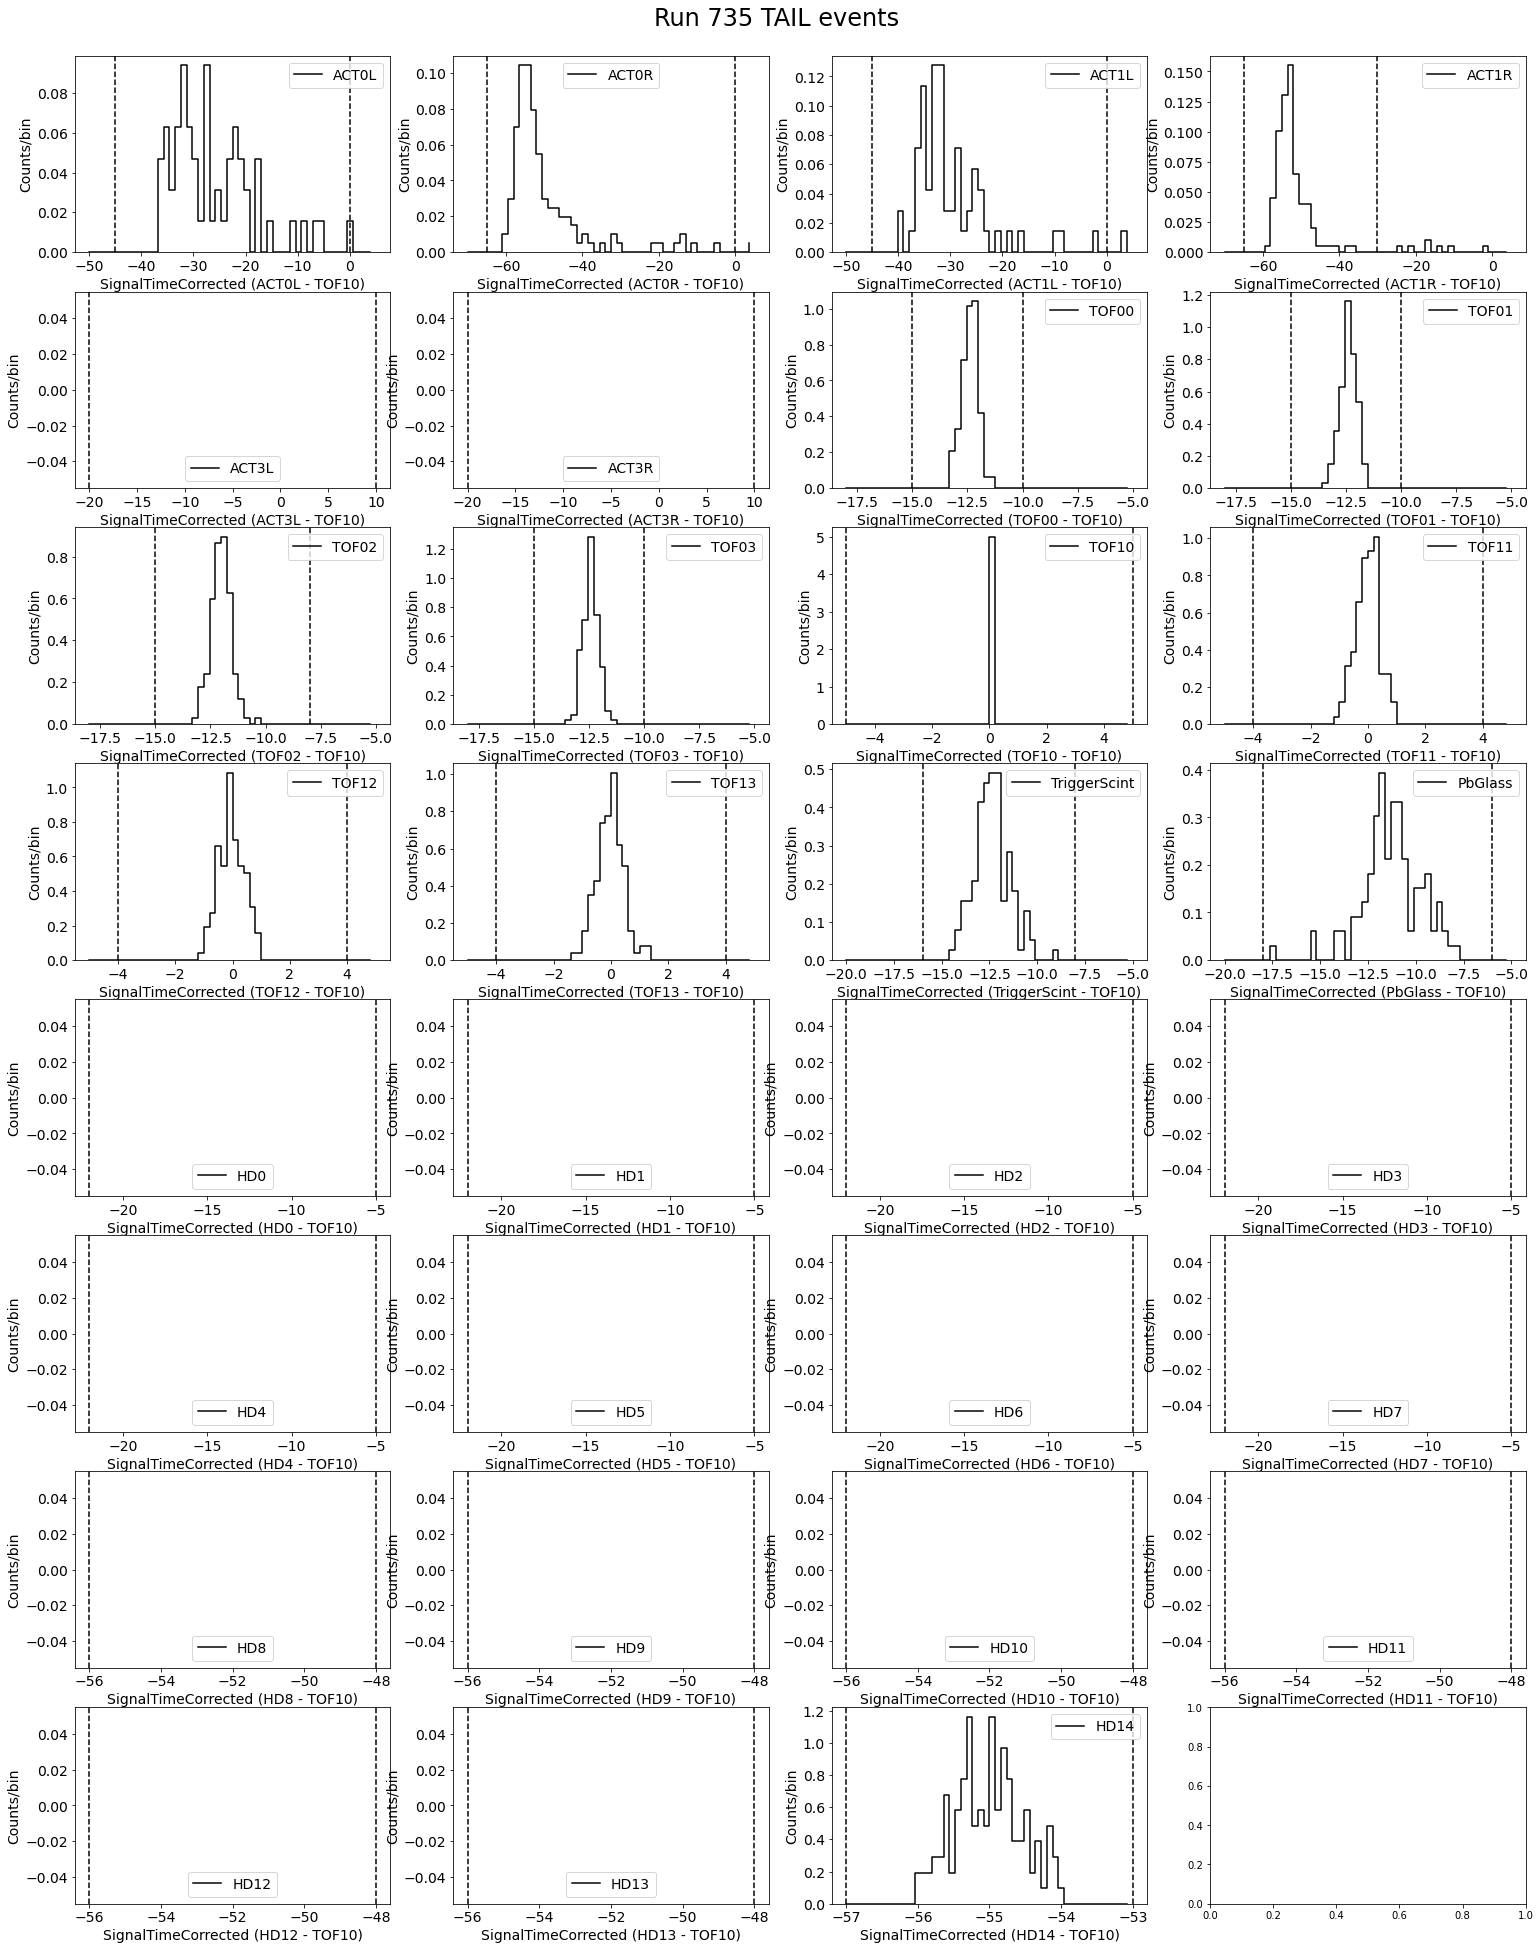

In [69]:
# Plot the timing cuts
evt_list = evt_list_PEAK #None
select_nonzero_peaks = True
windowInt = False
quantity = 'IntCharge'
logscale = False
normed = False
nbins = 50
t_range = [-60,-45]
time_ranges = {
    'ACT0L': [-50,5],
    'ACT0R': [-70,5],
    'ACT1L': [-50,5],
    'ACT1R': [-70,5],
    'ACT3L': [-25,20],
    'ACT3R': [-25,20],
    'TOF00': [-18,-5],
    'TOF01': [-18,-5],
    'TOF02': [-18,-5],
    'TOF03': [-18,-5],
    'TOF10': [-5,5],
    'TOF12': [-5,5],
    'TOF13': [-5,5],
    'TOF11': [-5,5],
    'TriggerScint': [-20,-5],
    'PbGlass': [-20,-5],
    'HD0': [-30,5],
    'HD1': [-30,5],
    'HD2': [-30,5],
    'HD3': [-30,5],
    'HD4': [-30,5],
    'HD5': [-30,5],
    'HD6': [-30,5],
    'HD7': [-30,5],
    'HD8': [-60,-45],
    'HD9': [-60,-45],
    'HD10': [-60,-45],
    'HD11': [-60, -45],
    'HD12': [-60,-45],
    'HD13': [-60,-45],
    'HD14': [-57,-53]
}

timing_cuts = {
    'ACT0L': [-45,0],
    'ACT0R': [-65,0],
    'ACT1L': [-45,0],
    'ACT1R': [-65,-30],
    'ACT3L': [-20,10],
    'ACT3R': [-20,10],
    'TOF00': [-15,-10],
    'TOF01': [-15,-10],
    'TOF02': [-15,-8],
    'TOF03': [-15,-10],
    'TOF10': [-5,5],
    'TOF12': [-4,4],
    'TOF13': [-4,4],
    'TOF11': [-4,4],
    'TriggerScint': [-16,-8],
    'PbGlass': [-18,-6],
    'HD0': [-22,-5],
    'HD1': [-22,-5],
    'HD2': [-22,-5],
    'HD3': [-22,-5],
    'HD4': [-22,-5],
    'HD5': [-22,-5],
    'HD6': [-22,-5],
    'HD7': [-22,-5],
    'HD8': [-56,-48],
    'HD9': [-56,-48],
    'HD10': [-56,-48],
    'HD11': [-56,-48],
    'HD12': [-56,-48],
    'HD13': [-56,-48],
    'HD14': [-57,-53]    
}

# Create a grid of 8 rows x 4 columns
fig, axes = plt.subplots(8, 4, figsize=(26, 34))
flat_axes = axes.ravel()

fig.suptitle(f'Run {rnum} PEAK events', fontsize=24, y=0.9)

# Iterate based on the custom order
for key, ax in zip(hd.custom_order, flat_axes):

    # Select the detector.
    df_detector = df_dict[key]
    
    # Apply charge cuts.
    df_detector = df_detector[(df_detector.IntCharge > chg_cuts[key][0]) & (df_detector.IntCharge < chg_cuts[key][1])]

    # Combined dataframe
    df_combined = df_detector.merge(df_T1sel, on='event', suffixes=('_det', '_T1'))
    if(not(evt_list is None)):
        df_combined = df_combined[df_combined['event'].isin(evt_list)]
    pk_times = df_combined['SignalTimeCorrected_det'] - df_combined['SignalTimeCorrected_T1']
    
    # Create the plot
    hist, bin_edges = np.histogram(pk_times, bins=nbins, range=time_ranges[key], density=normed)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Gaussian fit
#     fit_start = 0
#     fit_end = -1
#     initial_params = [np.max(hist), np.mean(pk_times), np.std(pk_times)]
#     print(f"Initial params: {initial_params}")
#     popt, pcov = curve_fit(gauss, bin_centers[fit_start:fit_end], hist[fit_start:fit_end], p0=initial_params)
#     perr = np.sqrt(np.diag(pcov))
#     fit_curve = gauss(bin_centers[fit_start:fit_end], *popt)

    # Plot the fit peak
    ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges)[0], align='edge', color='white')
    ax.plot(bin_edges[:-1], hist, color='black', drawstyle='steps-post', label=f'{key}')
    ax.axvline(timing_cuts[key][0],color='black',linestyle='--')
    ax.axvline(timing_cuts[key][1],color='black',linestyle='--')
#    ax.plot(bin_centers[fit_start:fit_end], fit_curve, '--', color='red', linewidth=2.0, alpha=1.0)
    ax.legend(fontsize=14)

    ax.set_xlabel(f"SignalTimeCorrected ({key} - TOF10)",fontsize=14)
    ax.set_ylabel("Counts/bin",fontsize=14)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    if(logscale): ax.set_yscale('log')
        
plt.savefig(f"timing_PEAK.pdf", bbox_inches='tight')

Initial params: [2843, -54.87003633620264, 2.336440779063675]


,event,iPeak,nPeaks,timeStamp,triggerTime,Pedestal,PedestalSigma,PeakVoltage,PeakTime,SignalTime,...,IntCharge_T1,SignalTimeCorrected_T1,IntPE_T1,MaxVoltage_T1,WholeWaveformInt_T1,nWindowPeaks_T1,WindowIntCharge_T1,WindowIntPE_T1,spillNumber_T1,SignalTimeCorrected_rel
0,0,0,1,1690843780,303845363,1.921429,0.001370,1.663730,91.0,86.481955,...,0.172145,73.758987,111.641874,0.969256,39.703295,-1.0,-1,-1,-1.0,-48.955654
1,1,0,1,1690843780,305142643,1.922948,0.000707,0.794898,105.0,100.693378,...,0.126460,71.726408,82.013787,0.675556,26.739067,-1.0,-1,-1,-1.0,-54.752257
2,4,0,1,1690843780,306108993,1.922586,0.000706,0.902913,89.0,83.249324,...,0.067896,66.760384,44.033118,0.404682,16.895010,-1.0,-1,-1,-1.0,-55.729962
3,9,0,1,1690843780,306947819,1.922763,0.000690,0.938484,99.0,94.533616,...,0.093693,73.178176,60.763297,0.540668,22.388095,-1.0,-1,-1,-1.0,-54.769340
4,11,0,1,1690843780,307205317,1.922938,0.000702,0.853108,105.0,101.034434,...,0.075209,78.292303,48.775398,0.440205,18.395667,-1.0,-1,-1,-1.0,-54.581653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,24933,0,1,1690845366,-1213763535,1.923150,0.000598,0.713732,91.0,86.763660,...,0.120293,65.788854,78.014136,0.692106,27.446029,-1.0,-1,-1,-1.0,-54.943149
6212,24936,0,1,1690845366,-1213606045,1.923020,0.000712,0.780445,101.0,96.593777,...,0.089221,74.969155,57.862781,0.558562,20.355857,-1.0,-1,-1,-1.0,-55.026663
6213,24937,0,1,1690845366,-1213512203,1.922727,0.000736,0.708368,99.0,94.222725,...,0.134555,71.776108,87.263404,0.682097,29.298343,-1.0,-1,-1,-1.0,-54.641631
6214,24941,0,1,1690845366,-1212705795,1.922845,0.000597,0.768018,95.0,89.489530,...,0.066359,79.701611,43.036380,0.390471,13.569629,-1.0,-1,-1,-1.0,-55.055256


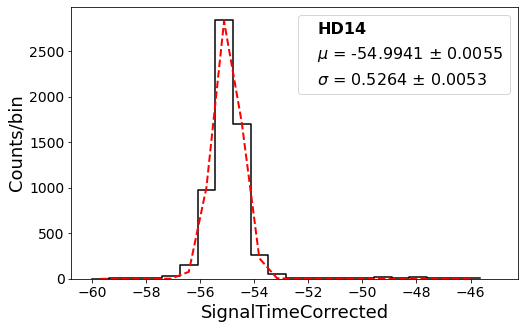

In [17]:
detectors = hd.custom_order #[k for k in df_dict.keys()]
idet = 30
detector = detectors[idet]
df_detector = df_dict[detector]
df_detector = df_detector[(df_detector.IntCharge > chg_cuts[detector][0]) & (df_detector.IntCharge < chg_cuts[detector][1])]
df_combined = df_detector.merge(df_T1sel, on='event', suffixes=('', '_T1'))
df_combined['SignalTimeCorrected_rel'] = df_combined['SignalTimeCorrected'] - df_combined['SignalTimeCorrected_T1']
timing_plot(detectors[idet],df_combined['SignalTimeCorrected_rel'],[-60,-45],23)
#timing_plot(detectors[idet],pk_times,[-200,200],23)
df_combined

In [18]:
final_df, ntot_evts, ntot_spills, ntot_tagged_evts = hd.timing_analysis_corrected(df_dict, [60,86], chg_cuts, timing_cuts, low_radiation=low_radiation, debug=True)

[Detector ACT0L] events go from 0 to 24949 for total of 24950
[Detector ACT1L] events go from 0 to 24949 for total of 24950
[Detector ACT3R] events go from 0 to 24949 for total of 24950
[Detector TOF01] events go from 0 to 24949 for total of 24950
[Detector HD3] events go from 0 to 24949 for total of 24950
[Detector HD11] events go from 0 to 24949 for total of 24950
[Detector HD10] events go from 0 to 24949 for total of 24950
[Detector HD2] events go from 0 to 24949 for total of 24950
[Detector TOF00] events go from 0 to 24949 for total of 24950
[Detector HD0] events go from 0 to 24949 for total of 24950
[Detector TOF02] events go from 0 to 24949 for total of 24950
[Detector HD12] events go from 0 to 24949 for total of 24950
[Detector HD13] events go from 0 to 24949 for total of 24950
[Detector TOF03] events go from 0 to 24949 for total of 24950
[Detector HD1] events go from 0 to 24949 for total of 24950
[Detector TOF13] events go from 0 to 24949 for total of 24950
[Detector HD5] event

/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


--> returning 24176 events
T2 filter passed 24174 of 24176 with 0 duplicates
--> returning 24174 events

ACT0L filter passed 28830 of 36781 with 10930 duplicates
--> returning 23182 events
ACT0R filter passed 31197 of 34566 with 13250 duplicates
--> returning 24274 events
ACT0_combined filter passed 21094 of 22910 with 0 duplicates
--> returning 21094 events
ACT1L filter passed 24008 of 30062 with 4176 duplicates
--> returning 21912 events
ACT1R filter passed 24050 of 32516 with 1237 duplicates
--> returning 23428 events
ACT1_combined filter passed 19216 of 20952 with 0 duplicates
--> returning 19216 events
ACT3 total number of valid events: 22831
HD0 filter passed 5241 of 34461 with 151 duplicates
--> returning 5164 events
HD0 filter passed 163 of 5164 with 0 duplicates
--> returning 163 events
HD0: 163 of 34950 events after filter
HD1 filter passed 4737 of 37732 with 242 duplicates
--> returning 4616 events
HD1 filter passed 221 of 4616 with 0 duplicates
--> returning 221 events
HD1:

In [ ]:
final_df, ntot_evts, ntot_spills, ntot_tagged_evts = hd.timing_analysis(df_dict, pb_timing_range, tof0_timing_range, tof0_charge_range, 
                    tof1_timing_range, tof1_charge_range, t2_timing_range, t2_charge_range,
                    act0_timing_range, act0_charge_range, act1_timing_range, act1_charge_range,
                    act3_timing_range, hd_timing_ranges, hd_charge_ranges, low_radiation=low_radiation, debug=True)

### Timing cut table (*tbl.timingcuts*)

In [19]:
# Print timing cut table
cuts_hd14      = (final_df.hit_HD14 == 1)
cuts_hd14_tail = cuts_hd14 & (final_df.LG_IntCharge <  0.1)
cuts_hd14_peak = cuts_hd14 & (final_df.LG_IntCharge >= 0.1)

# Total numbers of events 
tot_hd14 = len(final_df[cuts_hd14])
tot_hd14_peak = len(final_df[cuts_hd14_peak])
tot_hd14_tail = len(final_df[cuts_hd14_tail])

# Cuts to evaluate.
cuts_ACT0      = (final_df.hit_ACT0 == 1)
cuts_ACT1      = (final_df.hit_ACT1 == 1)
cuts_ACT3      = (final_df.nohit_ACT3 == 1)
cuts_TOF0      = (final_df.hit_TOF0 == 1)
cuts_TOF1      = (final_df.hit_TOF1 == 1)
cuts_T2        = (final_df.hit_T2 == 1)
cuts_all       = cuts_ACT0 & cuts_ACT1 & cuts_ACT3 & cuts_TOF0 & cuts_TOF1 & cuts_T2

# Arrays for iterating through the cuts.
cuts_txt = ["HD14 hit only", "ACT0 hit", "ACT1 hit", "ACT3 no hit", "TOF0 hit", "TOF1 hit", "T2 hit", "All"]
cuts_arr = [cuts_hd14, cuts_ACT0, cuts_ACT1, cuts_ACT3, cuts_TOF0, cuts_TOF1, cuts_T2, cuts_all]

print("Cut & All evts (\\%) & Peak evts (\\%) & Tail evts (\\%)\\\\")
print("\hline")
for txt,cuts in zip(cuts_txt,cuts_arr):
    nall  = len(final_df[cuts_hd14 & cuts])
    npeak = len(final_df[cuts_hd14_peak & cuts])
    ntail = len(final_df[cuts_hd14_tail & cuts])
    
    print(f"{txt} & {nall} ({nall/tot_hd14:.2f}) & {npeak} ({npeak/tot_hd14_peak:.2f}) & {ntail} ({ntail/tot_hd14_tail:.2f})\\\\")

Cut & All evts (\%) & Peak evts (\%) & Tail evts (\%)\\
\hline
HD14 hit only & 4685 (1.00) & 4484 (1.00) & 201 (1.00)\\
ACT0 hit & 4038 (0.86) & 3858 (0.86) & 180 (0.90)\\
ACT1 hit & 3605 (0.77) & 3437 (0.77) & 168 (0.84)\\
ACT3 no hit & 4344 (0.93) & 4170 (0.93) & 174 (0.87)\\
TOF0 hit & 4628 (0.99) & 4428 (0.99) & 200 (1.00)\\
TOF1 hit & 4658 (0.99) & 4458 (0.99) & 200 (1.00)\\
T2 hit & 4674 (1.00) & 4474 (1.00) & 200 (1.00)\\
All & 2842 (0.61) & 2713 (0.61) & 129 (0.64)\\


#### Gamma peaks plot (*fig.gamma_peaks*)

In [ ]:
fit_results, fit_arrays = hd.gamma_peak_plots(final_df, rnum, pbeam, base_dir='plt/gamma_peaks', nbins=80, range=[0,0.8], timing_cuts=False, low_radiation=False)

#### Timing and charge cuts plot for HD14 (*fig.hd14_cuts*)

In [ ]:
# Plot the timing and charge selections for HD14.

# Set up the figure.
fig, axes = plt.subplots(2, 1, figsize=(8, 10))
flat_axes = axes.ravel()
ax0, ax1 = flat_axes[0], flat_axes[1]

# Select the timing and charge information from the HD14 peaks dataframe.
df_hd14 = df_dict['HD14']
hd14_timing = df_hd14[(df_hd14.PeakTime > 0) & (df_hd14.IntCharge > 0.1)]['PeakTime']
#hd14_timing = df_hd14[df_hd14.PeakTime > 0]['PeakTime']
hd14_charge = df_hd14[df_hd14.IntCharge > 0.02]['IntCharge']

# Plot the timing information with cuts shown.
hist_timing, bin_edges_timing = np.histogram(hd14_timing, bins=50, range=[50,150])
bin_centers_timing = (bin_edges_timing[:-1] + bin_edges_timing[1:]) / 2
ax0.bar(bin_edges_timing[:-1], hist_timing, width=np.diff(bin_edges_timing)[0], align='edge', color='white')
ax0.plot(bin_edges_timing[:-1], hist_timing, color='black', drawstyle='steps-post')
ax0.axvline(hd_timing_ranges['HD14'][0],color='black',linestyle='--')
ax0.axvline(hd_timing_ranges['HD14'][1],color='black',linestyle='--')
ax0.set_xlabel("HD14 Peak Time (samples)",fontsize=14)
ax0.set_ylabel('Counts/bin',fontsize=14)
ax0.tick_params(axis="x", labelsize=14)
ax0.tick_params(axis="y", labelsize=14)

# Plot the charge information with cuts shown.
hist_charge, bin_edges_charge = np.histogram(hd14_charge, bins=50, range=[0,0.6])
bin_centers_charge = (bin_edges_charge[:-1] + bin_edges_charge[1:]) / 2
ax1.bar(bin_edges_charge[:-1], hist_charge, width=np.diff(bin_edges_charge)[0], align='edge', color='white')
ax1.plot(bin_edges_charge[:-1], hist_charge, color='black', drawstyle='steps-post')
ax1.axvline(hd_charge_ranges['HD14'][0],color='black',linestyle='--')
ax1.axvline(hd_charge_ranges['HD14'][1],color='black',linestyle='--')
ax1.set_xlabel("HD14 integrated charge (arbitrary units)",fontsize=14)
ax1.set_ylabel('Counts/bin',fontsize=14)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
plt.savefig("HD14_cuts.pdf", bbox_inches='tight')

In [ ]:
# Plot the timing and charge selections for T2.

# Set up the figure.
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
flat_axes = axes.ravel()
ax0, ax1 = flat_axes[0], flat_axes[1]

# Select the timing and charge information from the HD14 peaks dataframe.
df_T2 = df_dict['TriggerScint']
#T2_timing = df_T2[(df_T2.PeakTime > 0) & (df_T2.IntCharge > 0.0)]['PeakTime']
T2_timing = df_T2[(df_T2.SignalTimeCorrected > 0) & (df_T2.IntCharge > 0.0)]['SignalTimeCorrected']
T2_charge = df_T2[df_T2.IntCharge > 0.0]['IntCharge']

# Plot the timing information with cuts shown.
hist_timing, bin_edges_timing = np.histogram(T2_timing, bins=30, range=[20,100])
bin_centers_timing = (bin_edges_timing[:-1] + bin_edges_timing[1:]) / 2
ax0.bar(bin_edges_timing[:-1], hist_timing, width=np.diff(bin_edges_timing)[0], align='edge', color='white')
ax0.plot(bin_edges_timing[:-1], hist_timing, color='black', drawstyle='steps-post')
ax0.axvline(t2_timing_range[0],color='black',linestyle='--')
ax0.axvline(t2_timing_range[1],color='black',linestyle='--')
ax0.set_xlabel("T2 Peak Time (samples)",fontsize=14)
ax0.set_ylabel('Counts/bin',fontsize=14)
ax0.tick_params(axis="x", labelsize=14)
ax0.tick_params(axis="y", labelsize=14)

# Plot the charge information with cuts shown.
hist_charge, bin_edges_charge = np.histogram(T2_charge, bins=50, range=[0,0.125])
bin_centers_charge = (bin_edges_charge[:-1] + bin_edges_charge[1:]) / 2
ax1.bar(bin_edges_charge[:-1], hist_charge, width=np.diff(bin_edges_charge)[0], align='edge', color='white')
ax1.plot(bin_edges_charge[:-1], hist_charge, color='black', drawstyle='steps-post')
ax1.axvline(t2_charge_range[0],color='black',linestyle='--')
ax1.axvline(t2_charge_range[1],color='black',linestyle='--')
ax1.set_xlabel("T2 integrated charge (arbitrary units)",fontsize=14)
ax1.set_ylabel('Counts/bin',fontsize=14)
ax1.tick_params(axis="x", labelsize=14)
ax1.tick_params(axis="y", labelsize=14)
plt.savefig("T2_cuts.pdf", bbox_inches='tight')

#### HD14 histogram (*fig.gamma_peak_H14*)

In [20]:
def gauss(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

Uncalibrated histogram

Initial params: [334, 0.22792111439762, 0.05978843104670115]


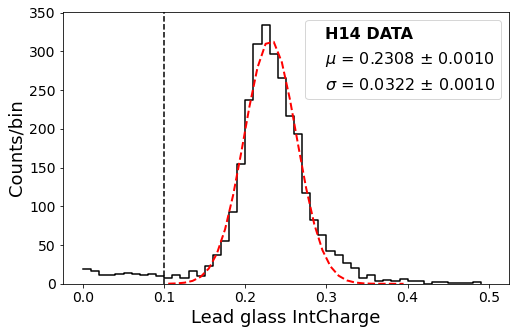

In [60]:
nbins = 50
e_range = [0,0.5]
fit_start = 10
fit_end = 40
normed = False
cuts_nominal = (final_df.hit_HD14 == 1) & (final_df.total_hits == 1) & (final_df.LG_nPeaks == 1)

# Set up the timing cuts
if(low_radiation):
    cuts_timing = (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
              (final_df.hit_TOF0 == 1) & (final_df.hit_T2 == 1)
else:
    cuts_timing = (final_df.hit_ACT0 == 1) & \
                        (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
                        (final_df.hit_TOF0 == 1) & (final_df.hit_TOF1 == 1) & (final_df.hit_T2 == 1)

# Convert the LG charge to energy
lg_energy = final_df[cuts_nominal & cuts_timing]['LG_IntCharge']
#lg_energy = lg_energy[lg_energy > 50]

# Create the plot
hist, bin_edges = np.histogram(lg_energy, bins=nbins, range=e_range, density=normed)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian fit
initial_params = [np.max(hist), np.mean(lg_energy), np.std(lg_energy)]
print(f"Initial params: {initial_params}")
popt, pcov = curve_fit(gauss, bin_centers[fit_start:fit_end], hist[fit_start:fit_end], p0=initial_params)
perr = np.sqrt(np.diag(pcov))
fit_curve = gauss(bin_centers[fit_start:fit_end], *popt)
        
# Plot the fit peak
fig = plt.figure(figsize=(8,5))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges)[0], align='edge', color='white')
plt.plot(bin_edges[:-1], hist, color='black', drawstyle='steps-post')
plt.plot(bin_centers[fit_start:fit_end], fit_curve, '--', color='red', linewidth=2.0, alpha=1.0)
plt.axvline(0.1,color='black',linestyle='--')

# Prepare the legend.
lbl1 = f"H14 DATA"
lbl2 = "$\mu$ = {:.4f} $\pm$ {:.4f}".format(popt[1],perr[1])
lbl3 = "$\sigma$ = {:.4f} $\pm$ {:.4f}".format(popt[2],perr[2])
legend_elements = [Line2D([0], [0], color='none', lw=0, label=lbl1),
                   Line2D([0], [0], color='none', lw=0, label=lbl2),
                   Line2D([0], [0], color='none', lw=0, label=lbl3)]
leg = plt.legend(handles=legend_elements, frameon=True, handlelength=0, fontsize=16)
for i, text in enumerate(leg.get_texts()):
    if i == 0:
        text.set_weight('bold')
    text.set_horizontalalignment('right')

plt.xlabel("Lead glass IntCharge",fontsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)

plt.savefig(f"DATA_gamma_peak_H14.pdf", bbox_inches='tight')
#plt.yscale('log')
#plt.ylim([0.1,np.max(h0[0])*1.5])
#plt.title(f"RUN 000{rnum}, p = + {pbeam/1000} GeV/c",fontsize=20)

Calibrated histogram

Initial params: [0.07142857142857142, 0.22792111439762, 0.05978843104670115]


/Users/jrenner/local/miniforge3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


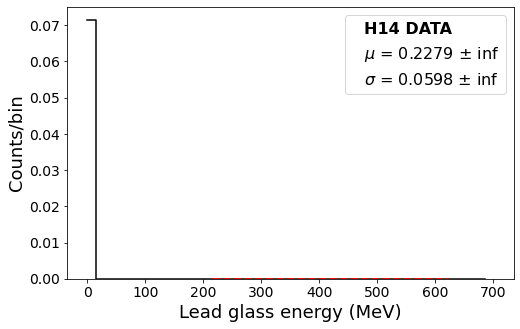

In [52]:
nbins = 50
e_range = [0,700]
fit_start = 15
fit_end = 45
normed = True
cuts_nominal = (final_df.hit_HD14 == 1) & (final_df.total_hits == 1) & (final_df.LG_nPeaks == 1)
ecal_b = -0.017
ecal_m = 6.15e-4

# Set up the timing cuts
if(low_radiation):
    cuts_timing = (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
              (final_df.hit_TOF0 == 1) & (final_df.hit_T2 == 1)
else:
    cuts_timing = (final_df.hit_ACT0 == 1) & \
                        (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
                        (final_df.hit_TOF0 == 1) & (final_df.hit_TOF1 == 1) & (final_df.hit_T2 == 1)

# Convert the LG charge to energy
lg_energy = (final_df[cuts_nominal & cuts_timing]['LG_IntCharge'] - ecal_b) / ecal_m
lg_energy = lg_energy[lg_energy > 50]

# Create the plot
hist, bin_edges = np.histogram(lg_energy, bins=nbins, range=e_range, density=normed)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Gaussian fit
initial_params = [np.max(hist), np.mean(lg_energy), np.std(lg_energy)]
print(f"Initial params: {initial_params}")
popt, pcov = curve_fit(gauss, bin_centers[fit_start:fit_end], hist[fit_start:fit_end], p0=initial_params)
perr = np.sqrt(np.diag(pcov))
fit_curve = gauss(bin_centers[fit_start:fit_end], *popt)
        
# Plot the fit peak
fig = plt.figure(figsize=(8,5))
plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges)[0], align='edge', color='white')
plt.plot(bin_edges[:-1], hist, color='black', drawstyle='steps-post')
plt.plot(bin_centers[fit_start:fit_end], fit_curve, '--', color='red', linewidth=2.0, alpha=1.0)

# Prepare the legend.
lbl1 = f"H14 DATA"
lbl2 = "$\mu$ = {:.4f} $\pm$ {:.4f}".format(popt[1],perr[1])
lbl3 = "$\sigma$ = {:.4f} $\pm$ {:.4f}".format(popt[2],perr[2])
legend_elements = [Line2D([0], [0], color='none', lw=0, label=lbl1),
                   Line2D([0], [0], color='none', lw=0, label=lbl2),
                   Line2D([0], [0], color='none', lw=0, label=lbl3)]
leg = plt.legend(handles=legend_elements, frameon=True, handlelength=0, fontsize=16)
for i, text in enumerate(leg.get_texts()):
    if i == 0:
        text.set_weight('bold')
    text.set_horizontalalignment('right')

plt.xlabel("Lead glass energy (MeV)",fontsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)

plt.savefig(f"DATA_gamma_peak_H14.pdf", bbox_inches='tight')
#plt.yscale('log')
#plt.ylim([0.1,np.max(h0[0])*1.5])
#plt.title(f"RUN 000{rnum}, p = + {pbeam/1000} GeV/c",fontsize=20)

#### Plot the timing for the peak and tail events

In [45]:
#df_T1sel
df_peak = final_df[cuts_nominal & cuts_timing & (final_df.LG_IntCharge >=  0.1)]
evt_list_PEAK = np.array(df_peak.event.values)
df_tail = final_df[cuts_nominal & cuts_timing & (final_df.LG_IntCharge <  0.1)]
evt_list_TAIL = np.array(df_tail.event.values)
#plt.hist(df_peak['LG_IntCharge'],bins=40)
#peak_T1 = df_peak.merge(df_T1sel, on='event', suffixes=('', '_T1'))
#peak_T1['SignalTimeCorrected_rel'] = peak_T1['SignalTimeCorrected'] - peak_T1['SignalTimeCorrected_T1']

In [35]:
peak_T1

,event,LG_iPeak,LG_nPeaks,LG_timeStamp,LG_triggerTime,LG_Pedestal,LG_PedestalSigma,LG_PeakVoltage,LG_PeakTime,LG_SignalTime,...,SignalTime,IntCharge,SignalTimeCorrected,IntPE,MaxVoltage,WholeWaveformInt,nWindowPeaks,WindowIntCharge,WindowIntPE,spillNumber
0,4,0,1,1690843780,306108993,1.915522,0.004197,0.393013,55.0,125.928945,...,66.760384,0.067896,66.760384,44.033118,0.404682,16.895010,-1.0,-1,-1,-1.0
1,13,0,1,1690843780,307325193,1.916237,0.004628,0.623687,59.0,131.122002,...,67.784352,0.066719,67.784352,43.269363,0.377095,15.636810,-1.0,-1,-1,-1.0
2,39,0,1,1690843780,311978481,1.915565,0.004826,0.485298,67.0,137.691452,...,82.300940,0.067634,82.300940,43.862902,0.424946,13.700667,-1.0,-1,-1,-1.0
3,52,0,1,1690843781,315091295,1.914891,0.003450,0.311833,71.0,142.897153,...,73.058791,0.091837,73.058791,59.559451,0.554218,19.384067,-1.0,-1,-1,-1.0
4,53,0,1,1690843781,315150603,1.915348,0.003939,0.733511,59.0,131.038324,...,78.347691,0.074337,78.347691,48.210102,0.449604,16.338752,-1.0,-1,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,24917,0,1,1690845366,-1217835605,1.915843,0.003196,0.400877,65.0,137.257682,...,76.660267,0.081579,76.660267,52.906699,0.436492,18.212886,-1.0,-1,-1,-1.0
2709,24932,0,1,1690845366,-1213998561,1.915696,0.004770,0.315076,59.0,131.666257,...,69.826748,0.082107,69.826748,53.249242,0.448699,18.159686,-1.0,-1,-1,-1.0
2710,24936,0,1,1690845366,-1213606045,1.916279,0.005143,0.491174,67.0,138.257000,...,74.969155,0.089221,74.969155,57.862781,0.558562,20.355857,-1.0,-1,-1,-1.0
2711,24941,0,1,1690845366,-1212705795,1.914372,0.005883,0.349891,61.0,132.743699,...,79.701611,0.066359,79.701611,43.036380,0.390471,13.569629,-1.0,-1,-1,-1.0


#### Select the peak and tail events

In [23]:
df_hd14 = final_df[cuts_nominal & cuts_timing]
evts_tail = df_hd14[df_hd14['LG_IntCharge'] < 0.1].event
energy_tail = df_hd14[df_hd14['LG_IntCharge'] < 0.1].LG_IntCharge
print("Tail events:",len(evts_tail))
evts_peak = df_hd14[(df_hd14['LG_IntCharge'] >= 0.1) & (df_hd14['LG_IntCharge'] < 0.4)].event
energy_peak = df_hd14[df_hd14['LG_IntCharge'] >= 0.1].LG_IntCharge
print("Peak events:",len(evts_peak))

Tail events: 129
Peak events: 2692


In [ ]:
print("Peak events")
print(evts_peak.values[0:40])

print("Tail events")
evts_tail.values

In [ ]:
energy_tail.values

In [ ]:
df_PbGlass = df_dict['TOF00']
df_PbGlass[df_PbGlass.event == 165]

In [ ]:
df_dict['HD14']['event'].values

#### Consider the timing difference between the LG and HD14

In [ ]:
# Select the peaks in each detector element for the events in the peak and tail.
df_HD = df_dict['HD14']
df_HD_peak = df_HD[df_HD['event'].isin(evts_peak)]
df_HD_tail = df_HD[df_HD['event'].isin(evts_tail)]
df_LG = df_dict['PbGlass']
df_LG_peak = df_LG[df_LG['event'].isin(evts_peak)]
df_LG_tail = df_LG[df_LG['event'].isin(evts_tail)]

# Handle duplicates in the HD array (rare cases in which we had multiple HD peaks but only 1 made cuts)
u, c = np.unique(df_HD_tail['event'], return_counts=True)
nduplicates = np.sum(c[c > 1])
print(nduplicates,"duplicate events in HD tail")
if(nduplicates > 0): 
    print("Dropping duplicates in HD peak dataframe ...")
    df_HD_peak = df_HD_peak.drop_duplicates(subset=['event'], keep='first')

u, c = np.unique(df_HD_peak['event'], return_counts=True)
nduplicates = np.sum(c[c > 1])
print(np.sum(c[c > 1]),"duplicate events in HD peak")
if(nduplicates > 0): 
    print("Dropping duplicates in HD tail dataframe ...")
    df_HD_tail = df_HD_tail.drop_duplicates(subset=['event'], keep='first')

# Get the tail time differences.
tdiff_tail = []
for evt,t_LG in zip(df_LG_tail['event'].values,df_LG_tail['PeakTime'].values):
    t_HD = df_HD_tail[df_HD_tail['event'] == evt]['PeakTime'].values[0]
    tdiff_tail.append(t_LG - t_HD)

# Get the peak time differences.
tdiff_peak = []
for evt,t_LG in zip(df_LG_peak['event'].values,df_LG_peak['PeakTime'].values):
    t_HD = df_HD_peak[df_HD_peak['event'] == evt]['PeakTime'].values[0]
    tdiff_peak.append(t_LG - t_HD)

In [ ]:
plt.hist(tdiff_tail,bins=40,label="Tail events",alpha=0.6)
plt.hist(tdiff_peak,bins=40,label="Peak events",alpha=0.6)
plt.yscale('log')
plt.xlabel('PeakTime$_{LG}$ - PeakTime$_{HD14}$',fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.legend(fontsize=14)

In [ ]:
_, ct = np.unique(df_HD_peak['event'],return_counts=True)
print("Maximum at",np.argmax(ct))
df_HD_peak[df_HD_peak['event'] == 23243]

#### Plot 2D histograms for the peak and tail events

In [ ]:
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="HD14", quantity1="PeakTime", detector2="TOF10", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[60,100]])
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="HD14", quantity1="PeakTime", detector2="TOF00", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[40,90]])
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="TOF00", quantity1="PeakTime", detector2="TOF10", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[40,90],[60,190]])
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="HD14", quantity1="PeakTime", detector2="PbGlass", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[40,120]])
hd.plot_2D_histogram(df_dict, evt_list=evts_peak, detector1="HD14", quantity1="PeakTime", detector2="TriggerScint", quantity2="PeakTime", base_dir='plt_2d_peak', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=12, range=[[75,125],[160,185]])

hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="HD14", quantity1="PeakTime", detector2="TOF10", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[60,100]])
hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="HD14", quantity1="PeakTime", detector2="TOF00", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[40,90]])
hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="TOF00", quantity1="PeakTime", detector2="TOF10", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[40,90],[60,190]])
hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="HD14", quantity1="PeakTime", detector2="PbGlass", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=20, range=[[75,125],[40,120]])
hd.plot_2D_histogram(df_dict, evt_list=evts_tail, detector1="HD14", quantity1="PeakTime", detector2="TriggerScint", quantity2="PeakTime", base_dir='plt_2d_tail', rnum=rnum, select_nonzero_peaks=True, logscale=False, nbins=12, range=[[75,125],[160,185]])

In [ ]:
hd2_events = final_df[(final_df.total_hits == 1) & (final_df.hit_HD2 == 1)]['event'].values

In [ ]:
df_HD14 = df_dict['HD14']
df_HD14[df_HD14['event'].isin(hd2_events)].head()

In [ ]:
df_HD2 = df_dict['HD2']
df_HD2_inpeak = df_HD2[df_HD2['event'].isin(evts_peak)]
plt.hist(df_HD2_inpeak[df_HD2_inpeak.IntCharge > 0.01].IntCharge,bins=50)

In [ ]:
# Plot the tail events control plots
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='nPeaks', select_nonzero_peaks=False, logscale=False, nbins=20)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='timeStamp', select_nonzero_peaks=False, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='triggerTime', select_nonzero_peaks=False, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='Pedestal', select_nonzero_peaks=False, logscale=True, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='PedestalSigma', select_nonzero_peaks=False, logscale=True, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='PeakVoltage', select_nonzero_peaks=True, logscale=False, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='PeakTime', select_nonzero_peaks=True, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='SignalTime', select_nonzero_peaks=True, logscale=False, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_tail, base_dir='plt_tail', rnum=rnum, quantity='IntCharge', select_nonzero_peaks=True, logscale=False, nbins=60)

# Plot the peak events control plots
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='nPeaks', select_nonzero_peaks=False, logscale=False, nbins=20)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='timeStamp', select_nonzero_peaks=False, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='triggerTime', select_nonzero_peaks=False, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='Pedestal', select_nonzero_peaks=False, logscale=True, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='PedestalSigma', select_nonzero_peaks=False, logscale=True, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='PeakVoltage', select_nonzero_peaks=True, logscale=False, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='PeakTime', select_nonzero_peaks=True, logscale=False, nbins=40)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='SignalTime', select_nonzero_peaks=True, logscale=False, nbins=60)
hd.plot_histograms_for_each_signal(df_dict, evt_list=evts_peak, base_dir='plt_peak', rnum=rnum, quantity='IntCharge', select_nonzero_peaks=True, logscale=False, nbins=60)

#### Show the effects of the ACT and TOF cuts

In [ ]:
cuts_all = (final_df.total_hits == 1) 
cuts_ACT0 = cuts_all #& (final_df.hit_ACT0 == 1)
cuts_ACT1 = cuts_ACT0 & (final_df.hit_ACT1 == 1)
cuts_ACT3 = cuts_ACT1 & (final_df.nohit_ACT3 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['LG_IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT0]['LG_IntCharge'],bins=40,label="HD14+ACT0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT1]['LG_IntCharge'],bins=40,label="HD14+ACT0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT3]['LG_IntCharge'],bins=40,label="HD14+ACT0/1/3")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title(f"RUN 000{rnum}, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

In [ ]:
cuts_all = (final_df.total_hits == 1) 
cuts_ACT0 = cuts_all #& (final_df.hit_ACT0 == 1)
cuts_ACT1 = cuts_ACT0 & (final_df.hit_ACT1 == 1)
cuts_ACT3 = cuts_ACT1 & (final_df.nohit_ACT3 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['LG_IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT0]['LG_IntCharge'],bins=40,label="HD14+ACT0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT1]['LG_IntCharge'],bins=40,label="HD14+ACT0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_ACT3]['LG_IntCharge'],bins=40,label="HD14+ACT0/1/3")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title(f"RUN 000{rnum}, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

#### Count the number of events in the tails

In [ ]:
cuts_nominal = (final_df.hit_HD14 == 1) & (final_df.total_hits == 1) & (final_df.LG_nPeaks == 1)
if(low_radiation):
    cuts_timing = (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
              (final_df.hit_TOF0 == 1) & (final_df.hit_T2 == 1)
else:
    cuts_timing = (final_df.hit_ACT0 == 1) & \
                        (final_df.hit_ACT1 == 1) & (final_df.nohit_ACT3 == 1) & \
                        (final_df.hit_TOF0 == 1) & (final_df.hit_TOF1 == 1) & (final_df.hit_T2 == 1)
normed=False
    
values_hd14 = final_df[cuts_nominal & cuts_timing]['LG_IntCharge']

ntail = len(values_hd14[values_hd14 < 0.1])
npeak = len(values_hd14[values_hd14 >= 0.1])
ftail = ntail/(npeak+ntail)
fpeak = npeak/(npeak+ntail)
print("Number of counts < 0.1:",ntail)
print("Number of counts >= 0.1:",npeak)
print("Ratio of tail/total events:",ftail)
print("Ratio of peak/total events:",fpeak)

fig = plt.figure(figsize=(14,7))
h0 = plt.hist(values_hd14,bins=80,label="HD14",range=[0,0.5],density=normed)
plt.xlabel("Lead glass charge",fontsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.title(f"RUN 000{rnum}, p = + 0.8 GeV/c;\n{ntail} tail events < 0.1 ({ftail*100:.2f}%), {npeak} peak events >= 0.1 ({fpeak*100:.2f}%)",fontsize=20)
plt.legend(fontsize=18)

In [ ]:
cuts_all = (final_df.total_hits == 1) 
cuts_TOF0 = cuts_all & (final_df.hit_TOF0 == 1)
cuts_TOF1 = cuts_TOF0 & (final_df.hit_TOF1 == 1)
cuts_T2 = cuts_TOF1 & (final_df.hit_T2 == 1)

fig = plt.figure(figsize=(14,7))
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_all]['LG_IntCharge'],bins=40,label="HD14")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_TOF0]['LG_IntCharge'],bins=40,label="HD14+TOF0")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_TOF1]['LG_IntCharge'],bins=40,label="HD14+TOF0/1")
plt.hist(final_df[(final_df.hit_HD14 == 1) & cuts_T2]['LG_IntCharge'],bins=40,label="HD14+TOF0/1/2")

plt.xlabel("Lead glass charge",fontsize=14)
plt.ylabel("Counts/bin",fontsize=14)
plt.title("RUN 000734, p = + 0.7 GeV/c",fontsize=20)
plt.legend()

In [ ]:
#plt.hist(df_dict['ACT3L'][df_dict['ACT3L']['PeakTime'] > 10]['PeakTime'],bins=100)
plt.hist(df_dict['ACT1L'][df_dict['ACT1L']['PeakTime'] > 10]['PeakTime'],bins=100)
#plt.hist(act0_combined['combined_charge'],bins=100)

In [ ]:
plt.hist(tof1_combined['combined_charge'],bins=100,range=[0,1])
#plt.hist(df_dict['TOF00']['PeakTime'],bins=100,range=[35,90])
#plt.hist(df_dict['TriggerScint']['IntCharge'],bins=100,range=[0,0.05])

In [ ]:
events = uproot.open("{}".format("../ntuples/ntuple_000734.root"))
main_keys = events.keys()

In [ ]:
dataframes

# 2. Plots of magnetic field map

In [ ]:
# Read the field map.
df = pd.read_csv('mfMapMeasured.txt', delim_whitespace=True, comment='%', header=None)

# Assign column names
df.columns = ['x', 'y', 'z', 'Bx', 'By', 'Bz']

# Compute the magnitude of the field
df['Bmag'] = np.sqrt(df['Bx']**2 + df['By']**2 + df['Bz']**2)

df.head(20)

In [ ]:
np.max(df['x'])

#### 1D plot (*fig.fieldmap*)

In [ ]:
df_center = df[(df['y'] == 0) & (df['x'] == 0)]
df_r1 = df[(df['y'] == 0) & (df['x'] == 15.0)]

# Central axis
By_center = df_center['By'].values
z_center  = df_center['z'].values

# Off-axis near smallest bore edge
By_r1 = df_r1['By'].values
z_r1  = df_r1['z'].values

plt.figure(figsize=(8,5))
plt.plot(z_center,By_center,linewidth=1,color='black',label="B$_y$ (r = 0 mm)")
plt.plot(z_r1,By_r1,linewidth=1,color='black',linestyle='--',label="B$_y$ (r = 15 mm)")
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)
plt.xlabel('Z (mm)',fontsize=14)
plt.ylabel('B$_{y}$ (T)',fontsize=14)
plt.legend(fontsize=17,loc=4)
plt.savefig("Bfieldmap_axial.pdf")

In [ ]:
print(z_center[By_center < -1.35])

In [ ]:
df_filtered = df[(df['y'] == 0) & (df['x'] == 0)]
Bx = df_filtered['Bx'].values
By = df_filtered['By'].values
Bz = df_filtered['Bz'].values
z  = df_filtered['z'].values

plt.figure(figsize=(10,6))
plt.plot(z,Bx,linewidth=2,color='red', label="B$_x$")
plt.plot(z,By,linewidth=2,color='black', label="B$_y$")
plt.plot(z,Bz,linewidth=2,color='blue', label="B$_z$")
plt.gca().tick_params(axis="x", labelsize=14)
plt.gca().tick_params(axis="y", labelsize=14)
plt.xlabel('Z (mm)',fontsize=14)
plt.ylabel('B$_{x,y,z}$ (T)',fontsize=14)
plt.legend(fontsize=18,loc=4)
plt.savefig("Bfieldmap_axial.pdf")

In [ ]:
Bd = np.trapz(z_center,By_center)/1000
print(f"Integrated field By = {Bd} T*m")

In [ ]:
# Geant4 field
z = np.linspace(-500,500,100)
fwhm_to_sigma = (2*(2*np.log(2))**0.5)
sigma = 150 / fwhm_to_sigma
bfield = -1.45*np.exp(-z**2/(2*sigma**2))
plt.plot(z,bfield)
plt.ylabel("B$_y$ (T)",fontsize=16)
plt.xlabel("z (mm)",fontsize=16)
#print(f"FWHM to sigma conversion factor: {fwhm_to_sigma}")

In [ ]:
Bd_sim = np.trapz(z,bfield)/1000
print(f"Integrated field simulated in Geant4 = {Bd_sim} T*m")

#### 2D plots

In [ ]:
# Filter dataframe for a specific y-plane, for example, y=0
y_plane = 0
#df_filtered = df[(df['y'] == y_plane) & (df['z'] > -100) & (df['z'] < 250)]
df_filtered = df[df['y'] == y_plane]

# Create a pivot table for the magnitude values
pivot = df_filtered.pivot(index='x', columns='z', values='Bmag').fillna(0)

# Create the heatmap
plt.figure(figsize=(10,6))
plt.imshow(pivot, aspect='auto', cmap='viridis', origin='lower', 
           extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()])
plt.colorbar(label='Field Magnitude (T)')
plt.title(f'Magnetic Field Magnitude in x-z plane at Y={y_plane}')
plt.xlabel('Z (mm)')
plt.ylabel('X (mm)')
plt.show()

In [ ]:
# Filter dataframe for a specific z-plane, e.g., z=0
z_plane = 75
df_filtered = df[df['z'] == z_plane]
arrow_scale = 1

# Create the quiver (arrow) plot
plt.figure(figsize=(12,8))
plt.quiver(df_filtered['x'], df_filtered['y'], arrow_scale*df_filtered['Bx'], arrow_scale*df_filtered['By'], 
           angles='xy', scale_units='xy', scale=1, color='blue', width=0.002)
plt.title(f'Magnetic Field Direction in x-y plane at Z={z_plane}')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.axis('equal')
plt.show()


# 3. Waveform analysis (*fig.waveform*)

In [ ]:
import json5
import sys
sys.path.append("..")
import waveform_analysis as wf

In [ ]:
# Open the run file and config file.
run_file = uproot.open("root_run_000735.root")
config = json5.load(open("../../../config/config_hodoscope.json"))['WaveAnalysis']

# Load the waveforms for HD14.
waveforms_HD14 = run_file['midas_data_D302']['Channel7'].array().to_numpy()

# Run the analysis of the waveforms.
analysis = wf.WaveformAnalysis(waveforms_HD14,
                            threshold=config["Thresholds"][0],
                            analysis_window=(config["AnalysisWindowLow"][0], config["AnalysisWindowHigh"][0]),
                            pedestal_window=(config["PedestalWindowLow"][0], config["PedestalWindowHigh"][0]),
                            reverse_polarity=(config["Polarity"][0]==0),
                            voltage_scale=config["VoltageScale"],
                            time_offset=config["TimeOffset"][0])
analysis.find_all_peak_voltages()

In [ ]:
evt = 20675
base_dir = "plt_waveforms"

fig, axs = plt.subplots(1, 1, figsize=(7,4))
fig.tight_layout()
axs.plot(waveforms_HD14[evt][0:220],color='black')
#plt.title(f"")

# Iterate over peak times and plot arrows
for peak in analysis.pulse_peak_times[evt]:

    # Divide out the 2 ns / sample.
    peak_sample = int(peak/2)
    
    # Get the corresponding ADC count for the peak time
    y_peak = waveforms_HD14[evt][int(peak/2)]
    
    # Plot the arrow. The -5 in dy is arbitrary and used to offset the arrow tip for visibility.
    axs.arrow(peak_sample, y_peak-400, 0, 15, head_width=5, head_length=250, fc='red', ec='red')

axs.grid(alpha=0.4)
axs.set_xlabel("Sample (2 ns)",fontsize=14)
axs.set_ylabel("ADC counts",fontsize=14)
axs.tick_params(axis="x", labelsize=14)
axs.tick_params(axis="y", labelsize=14)

# Label the different regions
axs.axvspan(0, 100, color='red', alpha=0.1)
axs.axvspan(150, 210, color='lightblue', alpha=0.5)
axs.text(20, 8500, 'Analysis', ha='center', va='top', fontsize=12, fontweight='bold', color='black')
axs.text(170, 8500, 'Pedestal', ha='center', va='top', fontsize=12, fontweight='bold', color='black')

out_dir = f"{base_dir}/HD14"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
plt.savefig(f"{out_dir}/wf_HD14_{evt}.pdf", bbox_inches='tight')
#plt.close()

# 4. Data processing

### Create dataframes for all runs

In [ ]:
ntuple_dir = "/Users/jrenner/local/jerenner/T9BeamTestAna/ntuple/"
ntuple_pd_dir = "/Users/jrenner/local/jerenner/T9BeamTestAna/ntuple_dataframes/"

In [ ]:
#runs = np.arange(630,766)
runs = [735]
for run in runs:
    ntuple_file = "{}/peakAnalysed_timeCorr_000735.root".format(ntuple_dir,run)
    output_dir = "{}/run000{}".format(ntuple_pd_dir,run)
    
    # Make sure the file exists
    if(not os.path.isfile(ntuple_file)):
        continue
    
    print("Creating dataframes for run",run,"...")
    
    # Create the dataframe dictionary
    df_dict = hd.ntuple_to_pd_multipeak(ntuple_file)

    # Save all the dataframes for this run
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for key, df in df_dict.items():
        filepath = os.path.join(output_dir, f"{key}.csv")
        df.to_csv(filepath, index=False)

### Plot all quantities for each signal for each run

In [ ]:
#runs = np.arange(786,788)
runs = [735]
for run in runs:
    rnum = f"000{run}"
    run_dir = "{}/run{}".format(ntuple_pd_dir, rnum)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = hd.read_dataframes_from_csv(run_dir)
    
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='nPeaks', select_nonzero_peaks=False, logscale=False, nbins=20)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='timeStamp', select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='triggerTime', select_nonzero_peaks=False, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='Pedestal', select_nonzero_peaks=False, logscale=True, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PedestalSigma', select_nonzero_peaks=False, logscale=True, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakVoltage', select_nonzero_peaks=True, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='PeakTime', select_nonzero_peaks=True, logscale=False, nbins=40)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='SignalTime', select_nonzero_peaks=True, logscale=False, nbins=60)
    hd.plot_histograms_for_each_signal(df_dict, base_dir='plt', rnum=rnum, quantity='IntCharge', select_nonzero_peaks=True, logscale=False, nbins=60)

## Compute and plot statistics for each run

In [ ]:
statistics_data = {}

runs = np.arange(630,766)
for run in runs:
    run_dir = "{}/run000{}".format(ntuple_pd_dir, run)
    
    # Make sure the run exists
    if(run < 720 or not os.path.isdir(run_dir)):
        continue
        
    print("Computing statistics for run",run)

    # Read in all dataframes for this run
    df_dict = hd.read_dataframes_from_csv(run_dir)
    
    # Compute statistics for this run and save them
    statistics_data[run] = {}
    for key in custom_order:
        statistics_data[run][key] = hd.compute_statistics(df_dict[key])

#### Plot summary statistics from each run

In [ ]:
statistics_keys = ['avg_nPeaks', 'avg_Pedestal', 'avg_PedestalSigma', 'peak_PeakVoltage', 'peak_PeakTime', 'peak_SignalTime', 'peak_IntCharge']
act_set = ['ACT0L', 'ACT0R', 'ACT1L', 'ACT1R', 'ACT3L', 'ACT3R', 'PbGlass']
tof_set = ['TOF00', 'TOF01', 'TOF02', 'TOF03', 'TOF10', 'TOF11', 'TOF12', 'TOF13', 'TriggerScint']
hd_set  = ['HD0', 'HD1', 'HD2', 'HD3', 'HD4', 'HD5', 'HD6', 'HD7', 'HD8', 'HD9', 'HD10', 'HD11', 'HD12', 'HD13', 'HD14']

hd.plot_statistics_vs_run(statistics_data, statistics_keys, act_set, base_dir='plt', signal_set_name='ACT')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, tof_set, base_dir='plt', signal_set_name='TOF')
hd.plot_statistics_vs_run(statistics_data, statistics_keys, hd_set, base_dir='plt', signal_set_name='HD')

---

# OLD CODE

## Single-peak analysis

### Runs 670 - 677: Trigger T0 and T2 Coincidence with Hodoscope OR Lead Glass - 1% Slit
#### Please note that ntuples 672 (700 MeV), 674 (900 MeV), 675 (1 GeV) and 716 (700 MeV) cannot be produced with Nick script. This is something that may need to be considered.

In [ ]:
# Convert the ROOT file to a CSV
run  = "000734"
path = "../ntuples/ntuple_"
df   = ntuple_to_pd(path + "{}.root".format(run))

In [ ]:
df.head(100)

## Peak time analysis

In [ ]:
# Create entries in dataframe for averages in peak times
df['PeakTimeACT0'] = (df['PeakTime0'] + df['PeakTime1'])/2
df['PeakTimeACT1'] = (df['PeakTime2'] + df['PeakTime3'])/2
df['PeakTimeACT3'] = (df['PeakTime4'] + df['PeakTime5'])/2
df['PeakVoltageACT3'] = (df['PeakVoltage4'] + df['PeakVoltage5'])/2
df['PeakTimeTOF0'] = (df['PeakTime8'] + df['PeakTime9'] + df['PeakTime10'] + df['PeakTime11'])/4
df['PeakTimeTOF1'] = (df['PeakTime12'] + df['PeakTime13'] + df['PeakTime14'] + df['PeakTime15'])/4

In [ ]:
rng_time = [0,200]
nbins_time = 100

fig = plt.figure(figsize=(18,7))

h_ACT0R = plt.hist(df['PeakTime0'],bins=nbins_time,range=rng_time,label="ACT0-R")
h_ACT0L = plt.hist(df['PeakTime1'],bins=nbins_time,range=rng_time,label="ACT0-L")
h_ACT1L = plt.hist(df['PeakTime2'],bins=nbins_time,range=rng_time,label="ACT1-R")
h_ACT1R = plt.hist(df['PeakTime3'],bins=nbins_time,range=rng_time,label="ACT1-L")
h_ACT3L = plt.hist(df['PeakTime4'],bins=nbins_time,range=rng_time,label="ACT3-R")
h_ACT3R = plt.hist(df['PeakTime5'],bins=nbins_time,range=rng_time,label="ACT3-L")

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="Trigger scintillator")

h_TOF00 = plt.hist(df['PeakTime8'],bins=nbins_time,range=rng_time,label='TOF0-0')
h_TOF01 = plt.hist(df['PeakTime9'],bins=nbins_time,range=rng_time,label='TOF0-1')
h_TOF02 = plt.hist(df['PeakTime10'],bins=nbins_time,range=rng_time,label='TOF0-2')
h_TOF03 = plt.hist(df['PeakTime11'],bins=nbins_time,range=rng_time,label='TOF0-3')

h_TOF10 = plt.hist(df['PeakTime12'],bins=nbins_time,range=rng_time,label='TOF1-0')
h_TOF11 = plt.hist(df['PeakTime13'],bins=nbins_time,range=rng_time,label='TOF1-1')
h_TOF12 = plt.hist(df['PeakTime14'],bins=nbins_time,range=rng_time,label='TOF1-2')
h_TOF13 = plt.hist(df['PeakTime15'],bins=nbins_time,range=rng_time,label='TOF1-3')

plt.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=14)
plt.savefig("peak_times.png", bbox_inches='tight')

In [ ]:
rng_time = [0,200]
nbins_time = 60
alpha_time = 0.8

fig = plt.figure(figsize=(18,7))

h_ACT0 = plt.hist(df['PeakTimeACT0'],bins=nbins_time,range=rng_time,label="ACT0 avg",alpha=alpha_time)
h_ACT1 = plt.hist(df['PeakTimeACT1'],bins=nbins_time,range=rng_time,label="ACT1 avg",alpha=alpha_time)
h_ACT3 = plt.hist(df[df['PeakVoltageACT3'] > 0.5]['PeakTimeACT3'],bins=nbins_time,range=rng_time,label="ACT3 avg (V$_{peak}$ > 0.5)",alpha=alpha_time)

h_TOF0 = plt.hist(df['PeakTimeTOF0'],bins=nbins_time,range=rng_time,label='T0 avg',alpha=alpha_time)
h_TOF1 = plt.hist(df['PeakTimeTOF1'],bins=nbins_time,range=rng_time,label='T1 avg',alpha=alpha_time)

h_trig = plt.hist(df['PeakTime6'],bins=nbins_time,range=rng_time,label="T2 avg",alpha=alpha_time)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel("Counts/bin",fontsize=18)
plt.xlabel("Peak time (ns)",fontsize=18)

plt.legend(loc=2,fontsize=18)
plt.savefig("peak_times_avg.png", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
h2_ACT3 = ax.hist2d(df['PeakTimeACT3'],df['PeakVoltageACT3'],bins=[30,30],norm=matplotlib.colors.LogNorm())
fig.colorbar(h2_ACT3[3],ax=ax)
plt.xlabel("ACT3 avg peak time (ns)",fontsize=12)
plt.ylabel("ACT3 avg peak voltage",fontsize=12)
plt.savefig("ACT3_voltage_vs_time.png", bbox_inches='tight')

## Hodoscope analysis
#### These cuts allow us to see the individual peaks in the LGCharge plot below
#### Please note these cuts are made just looking at the charge spectrum of the LG and the Hodoscope PMTs and cutting the tail, but perhaps this tail could be eliminated using cuts in the Aerogels (?)

In [ ]:
th_hd = 0.02
cut_LG  = (df['IntCharge16'] > 0.05)

cut_H0 =  df['IntCharge24'] > th_hd
cut_H1 =  df['IntCharge25'] > th_hd
cut_H2 =  df['IntCharge26'] > th_hd
cut_H3 =  df['IntCharge27'] > th_hd
cut_H4 =  df['IntCharge28'] > th_hd
cut_H5 =  df['IntCharge29'] > th_hd
cut_H6 =  df['IntCharge30'] > th_hd
cut_H7 =  df['IntCharge31'] > th_hd
cut_H8 =  df['IntCharge17'] > th_hd
cut_H9 =  df['IntCharge18'] > th_hd
cut_H10 = df['IntCharge19'] > th_hd
cut_H11 = df['IntCharge20'] > th_hd
cut_H12 = df['IntCharge21'] > th_hd
cut_H13 = df['IntCharge22'] > th_hd
cut_H14 = df['IntCharge23'] > th_hd

LG_cal = 1. #120/3.
#rng = [0, 500*3/120]
rng = [0.0, 1.5]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0 & cut_LG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)
  
 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);

## Fitting the Lead Glass Charge Peaks (HodosCope Peaks)
#### Just a regular gaussian fit using Scipy CurveFit

In [ ]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [ ]:
data_H14 = df[cut_H14 & cut_LG]['IntCharge16']*LG_cal
data_H13 = df[cut_H13 & cut_LG]['IntCharge16']*LG_cal
data_H12 = df[cut_H12 & cut_LG]['IntCharge16']*LG_cal
data_H11 = df[cut_H11 & cut_LG]['IntCharge16']*LG_cal
data_H10 = df[cut_H10 & cut_LG]['IntCharge16']*LG_cal
data_H9  = df[cut_H9  & cut_LG]['IntCharge16']*LG_cal
data_H8  = df[cut_H8  & cut_LG]['IntCharge16']*LG_cal
data_H7  = df[cut_H7  & cut_LG]['IntCharge16']*LG_cal
data_H6  = df[cut_H6  & cut_LG]['IntCharge16']*LG_cal
data_H5  = df[cut_H5  & cut_LG]['IntCharge16']*LG_cal
data_H4  = df[cut_H4  & cut_LG]['IntCharge16']*LG_cal
data_H3  = df[cut_H3  & cut_LG]['IntCharge16']*LG_cal
data_H2  = df[cut_H2  & cut_LG]['IntCharge16']*LG_cal
data_H1  = df[cut_H1  & cut_LG]['IntCharge16']*LG_cal
data_H0  = df[cut_H0  & cut_LG]['IntCharge16']*LG_cal

datas = [data_H0, data_H1, data_H2, data_H3, data_H4, 
         data_H5, data_H6, data_H7, data_H8, data_H9, 
         data_H10, data_H11, data_H12, data_H13, data_H14]

labels = ["H0", "H1", "H2", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10", "H11", "H12", "H13", "H14"]

### This is not automated, you need to chage some values as you change the run, such as h, h decreasing and the text positioning since the counts decrease with the beam momentum

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))
h = 1400
means = []

for i,j in zip(datas, labels):    
    data = i

    hist, bin_edges = np.histogram(data, bins='auto') 

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    def gaussian(x, amplitude, mean, stddev):
        return amplitude * norm.pdf(x, loc=mean, scale=stddev)

    # Parámetros iniciales para el ajuste (estimaciones iniciales)
    initial_params = [1.0, 0.0, 1.0]

    # Realiza el ajuste
    popt, _ = curve_fit(gaussian, bin_centers, hist, p0=initial_params)

    # Crea una curva con los parámetros ajustados
    fit_curve = gaussian(bin_centers, *popt)

    # Grafica el histograma y la curva ajustada
    plt.hist(data, bins='auto', alpha=0.6, label=j);
    plt.plot(bin_centers, fit_curve, 'r-', alpha=0.6)
    plt.text(0.9, h, 'StdDev/Mean {}: {:.2f}'.format(j, popt[2]/popt[1]),fontsize=15)

    plt.legend()
    
    plt.xlabel('Lead Glass (charge)',fontsize=20);
    plt.ylabel('Counts/bin',fontsize=20);
    plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);
    
    plt.xlim(0., 1.5)
    
    h -= 87
    means.append(popt[1])

    print('Valores del ajuste para {}:'.format(j))
    print('Mean: {:.2f}'.format(popt[1]))
    print('StdDev: {:.2f}'.format(popt[2]))
    print(' ')

# Try fitting just a determined range

In [ ]:
#fig, ax = plt.subplots(figsize=(12, 6.0))
#h = 500
#
#for i,j in zip(datas, labels):    
#    data = i
#
#    hist, bin_edges = np.histogram(data, bins='auto') 
#
#    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#
#    def gaussian(x, amplitude, mean, stddev):
#        return amplitude * norm.pdf(x, loc=mean, scale=stddev)
#    
#    # Limita los datos y el eje x hasta cierto valor máximo (por ejemplo, x = 6)
#    max_x_value = 2.2
#    mask = bin_centers <= max_x_value
#    filtered_x = bin_centers[mask]
#    filtered_hist = hist[mask]
#
#
#    # Parámetros iniciales para el ajuste (estimaciones iniciales)
#    initial_params = [1.0, 0.0, 1.0]
#
#    # Realiza el ajuste
#    popt, _ = curve_fit(gaussian, filtered_x, filtered_hist, p0=initial_params)
#
#    # Crea una curva con los parámetros ajustados
#    fit_curve = gaussian(filtered_x, *popt)
#
#    # Grafica el histograma y la curva ajustada
#    plt.hist(data, bins='auto', alpha=0.6, label=j);
#    plt.plot(filtered_x, fit_curve, 'r-', alpha=0.6)
#    plt.text(2.15, h, 'StdDev {}: {:.2f}'.format(j, popt[2]),fontsize=15)
#
#    plt.legend()
#    
#    plt.xlabel('Counts/bin',fontsize=20);
#    plt.ylabel('Lead Glass (charge)',fontsize=20);
#    plt.title("Run {}, p = +800 MeV/c".format(run),fontsize=20);
#    
#    plt.xlim(0.4, 3.2)
#    
#    h -= 27
#
#    #print('Valores del ajuste:')
#    #print('Amplitude: {:.2f}'.format(popt[0]))
#    #print('Mean: {:.2f}'.format(popt[1]))
#    #print('StdDev: {:.2f}'.format(popt[2]))

# 2D Plot Expected Tagged Photon Energy vs. Lead Glass Charge

#### hit_energy values are the "expected gamma energy", computed by Josh

In [ ]:
hit_energy = [0.1595155500109545, 0.16918666630815957, 0.17050944491673403, 0.18508668641801915,
             0.1883263228952287, 0.20450156481839696, 0.21056117899451413, 0.22867222330704012,
             0.23899202319688614, 0.25950074031219433, 0.27649806820124223, 0.30005667059694635,
             0.32806001869009743, 0.3556345402074757, 0.40311754765565394]

#### IMPORTANT: Please note that you need to change the run momentum in this next cell

In [ ]:
run_momentum = 500

actual_means = means[::-1]
e_gamma_expected = [run_momentum - i*1000 for i in hit_energy[::-1]]

In [ ]:
plt.scatter(actual_means, e_gamma_expected);

plt.xlabel('Lead Glass Charge [Arbitrary Unit]');
plt.ylabel('Tagged Photon Expected Momentum [MeV/c]');

plt.title("Run {}, p = +500 MeV/c".format(run),fontsize=20);

# Aerogel Charged Particle Veto
#### Akira suggested we could use Aerogel 3 as charged particle veto ensuring only non-charged particles pass through it. Aerogels 0 & 1 can be used as veto in the opposite way. These could make us get rid of the tails that appear as beam momentum increases (see peak plots for 1200 MeV)

In [ ]:
plt.hist(df['IntCharge4'], bins=40, alpha=0.7);
plt.hist(df['IntCharge5'], bins=40, alpha=0.7);

plt.yscale('log');

plt.xlabel('Aerogel 3R & 3L Charge [Arbitrary Unit]');
plt.ylabel('Counts/bins');

In [ ]:
fig = plt.figure(figsize=(18,7))

ax1 = fig.add_subplot(121)
ax1.hist(df['IntCharge0'], bins=40, alpha=0.7, label='AG0R');
ax1.hist(df['IntCharge1'], bins=40, alpha=0.7, label='AG0L');

ax1.set_yscale('log');

ax1.set_xlabel('Aerogel 0R & 0L Charge [Arbitrary Unit]');
ax1.set_ylabel('Counts/bins');
plt.legend();

ax2 = fig.add_subplot(122)
ax2.hist(df['IntCharge2'], bins=40, alpha=0.7, label='AG1R');
ax2.hist(df['IntCharge3'], bins=40, alpha=0.7, label='AG1L');

ax2.set_yscale('log');

ax2.set_xlabel('Aerogel 1R & 1L Charge [Arbitrary Unit]');
ax2.set_ylabel('Counts/bins');
plt.legend();

#### Actual cuts for the aerogels. Many thresholds were tested and it seems like we cannot get rid of the tails using Aerogels.

In [ ]:
ag01_th = 0.0
ag3_th  = 0.1

cut_AG0R = df['IntCharge0'] > ag01_th
cut_AG0L = df['IntCharge1'] > ag01_th
cut_AG1R = df['IntCharge2'] > ag01_th
cut_AG1L = df['IntCharge3'] > ag01_th
cut_AG3R = df['IntCharge4'] < ag3_th
cut_AG3L = df['IntCharge5'] < ag3_th

cut_AG = cut_AG0R & cut_AG0L & cut_AG1R & cut_AG1L & cut_AG3R & cut_AG3L

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6.0))

plt.hist(df[cut_H14 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H14", alpha=0.8, range=rng)
plt.hist(df[cut_H13 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H13", alpha=0.8, range=rng)
plt.hist(df[cut_H12 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H12", alpha=0.8, range=rng)
plt.hist(df[cut_H11 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H11", alpha=0.8, range=rng)
plt.hist(df[cut_H10 & cut_LG & cut_AG]['IntCharge16']*LG_cal, bins='auto', label="H10", alpha=0.8, range=rng)
plt.hist(df[cut_H9  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H9",  alpha=0.8, range=rng)
plt.hist(df[cut_H8  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H8",  alpha=0.8, range=rng)
plt.hist(df[cut_H7  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H7",  alpha=0.8, range=rng)
plt.hist(df[cut_H6  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H6",  alpha=0.8, range=rng)
plt.hist(df[cut_H5  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H5",  alpha=0.8, range=rng)
plt.hist(df[cut_H4  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H4",  alpha=0.8, range=rng)
plt.hist(df[cut_H3  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H3",  alpha=0.8, range=rng)
plt.hist(df[cut_H2  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H2",  alpha=0.8, range=rng)
plt.hist(df[cut_H1  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H1",  alpha=0.8, range=rng)
plt.hist(df[cut_H0  & cut_LG & cut_AG]['IntCharge16']*LG_cal,  bins='auto', label="H0",  alpha=0.8, range=rng)

 
plt.legend()


plt.xlabel("Lead Glass (charge)",fontsize=20)
plt.ylabel("Counts/bin",fontsize=20)
#plt.yscale('log')
plt.title("Run {}, p = +1200 MeV/c".format(run), fontsize=20);